In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Add, Multiply, Reshape, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
import tensorflow as tf

# Function to import dense VAE

In [26]:
# On importe le VAE pour voir ce que ça donne en sortie du VAE en terme de reproduction de la forme et donc du shear

def load_vae_conv(path,nb_of_bands):
    
    batch_size = 100
    original_dim = 64*64*nb_of_bands
    epsilon_std = 1.0
    
    input_shape = (64,64,nb_of_bands)
    #original_dim = np.prod(input_shape)
    latent_dim = 10
    hidden_dim = 256
    filters = [32,64, 128, 256]
    kernels = [3,3,3,3]

    def build_encoder(latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus', nb_of_bands = nb_of_bands):
        if nb_of_bands == 1 :
            input_layer = Input(shape=(64,64))
        else : 
            input_layer = Input(shape=(64,64,nb_of_bands))
        r = Reshape((64,64,nb_of_bands))(input_layer)
        h = BatchNormalization()(r)
        for i in range(len(filters)):
            h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
            h = PReLU()(h)
            h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
            h = PReLU()(h)
        h = Flatten()(h)
        h = Dense(hidden_dim, activation=dense_activation)(h)
        h = PReLU()(h)
        mu = Dense(latent_dim)(h)
        sigma = Dense(latent_dim, activation='softplus')(h)
        return Model(input_layer, [mu, sigma])

    encoder = build_encoder(latent_dim, hidden_dim, filters, kernels)

        # Def decoder
    def build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
        input_layer = Input(shape=(latent_dim,))
        h = Dense(hidden_dim, activation=dense_activation)(input_layer)
        h = PReLU()(h)
        w = int(np.ceil(input_shape[0]/2**(len(filters))))
        h = Dense(w*w*filters[-1], activation=dense_activation)(h)
        h = PReLU()(h)
        h = Reshape((w,w,filters[-1]))(h)
        for i in range(len(filters)-1,-1,-1):
            h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
            h = PReLU()(h)
            h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
            h = PReLU()(h)
        h = Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same')(h)
        cropping = int(h.get_shape()[1]-input_shape[0])
        if cropping>0:
            print('in cropping')
            if cropping % 2 == 0:
                h = Cropping2D(cropping/2)(h)
            else:
                h = Cropping2D(((cropping//2,cropping//2+1),(cropping//2,cropping//2+1)))(h)
        if (input_shape ==(64,64,1)):
            h = Reshape((64,64))(h)

        return Model(input_layer, h)

    decoder = build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None)


    if (nb_of_bands == 1):
        input_vae = Input(shape=(64,64))
    else : 
        input_vae = Input(shape=(64,64, nb_of_bands))
    
    output_encoder = encoder(input_vae)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))(output_encoder)

    vae_loaded = Model(input_vae, decoder(z))
    latest = tf.train.latest_checkpoint(path)
    vae_loaded.load_weights(latest)
    
    #vae_loaded.load_weights(path)
    return vae_loaded, encoder

In [3]:
# On importe le VAE pour voir ce que ça donne en sortie du VAE en terme de reproduction de la forme et donc du shear

def load_vae_conv_2(path,nb_of_bands):
    
    batch_size = 100
    original_dim = 64*64*nb_of_bands
    epsilon_std = 1.0
    
    input_shape = (64,64,nb_of_bands)
    #original_dim = np.prod(input_shape)
    latent_dim = 10
    hidden_dim = 256
    filters = [32,64, 128, 256]
    kernels = [3,3,3,3]

    def build_encoder(latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus', nb_of_bands = nb_of_bands):
        if nb_of_bands == 1 :
            input_layer = Input(shape=(64,64))
        else : 
            input_layer = Input(shape=(64,64,nb_of_bands))
        r = Reshape((64,64,nb_of_bands))(input_layer)
        h = BatchNormalization()(r)
        for i in range(len(filters)):
            h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
            h = PReLU()(h)
            h = MaxPool2D((2,2))(h)
            h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
            h = PReLU()(h)
            h = BatchNormalization()(h)
        h = Flatten()(h)
        h = Dense(hidden_dim, activation=dense_activation)(h)
        h = PReLU()(h)
        mu = Dense(latent_dim)(h)
        sigma = Dense(latent_dim, activation='softplus')(h)
        return Model(input_layer, [mu, sigma])

    encoder = build_encoder(latent_dim, hidden_dim, filters, kernels)

    # Def decoder
    def build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
        input_layer = Input(shape=(latent_dim,))
        h = Dense(hidden_dim, activation=dense_activation)(input_layer)
        h = PReLU()(h)
        w = int(np.ceil(input_shape[0]/2**(len(filters))))
        h = Dense(w*w*filters[-1], activation=dense_activation)(h)
        h = PReLU()(h)
        h = Reshape((w,w,filters[-1]))(h)
        for i in range(len(filters)-1,-1,-1):
            h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
            h = PReLU()(h)
            h = UpSampling2D((2,2))(h)
            h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
            h = PReLU()(h)
            h = BatchNormalization()(h)
        h = Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same')(h)
        cropping = int(h.get_shape()[1]-input_shape[0])
        if cropping>0:
            print('in cropping')
            if cropping % 2 == 0:
                h = Cropping2D(cropping/2)(h)
            else:
                h = Cropping2D(((cropping//2,cropping//2+1),(cropping//2,cropping//2+1)))(h)
        if (input_shape ==(64,64,1)):
            h = Reshape((64,64))(h)

        return Model(input_layer, h)

    decoder = build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None)


    if (nb_of_bands == 1):
        input_vae = Input(shape=(64,64))
    else : 
        input_vae = Input(shape=(64,64, nb_of_bands))
    
    output_encoder = encoder(input_vae)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))(output_encoder)

    vae_loaded = Model(input_vae, decoder(z))
    latest = tf.train.latest_checkpoint(path)
    vae_loaded.load_weights(latest)
    
    #vae_loaded.load_weights(path)
    return vae_loaded, encoder

# Loading the trained VAE

In [4]:
vae_lsst_r_band_conv, encoder_R = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v6/mse/',1)

Instructions for updating:
Colocations handled automatically by placer.


In [54]:
vae_lsst_r_band_conv, encoder_R = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v5/',1)

In [19]:
vae_lsst_r_band_conv_64, encoder_R_64 = load_vae_conv('/sps/lsst/users/barcelin/weights/R_band/VAE/noisy/v9_64ld/mse/',1)

In [5]:
vae_lsst_conv, encoder_LSST = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v5/mse/',6)

In [6]:
vae_lsst_euclid_conv, encoder_LSST_EUCLID = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST_EUCLID/VAE/noisy/v3/',10)#/sps/lsst/users/barcelin/weights/LSST_EUCLID/noisy/noisy

# Plot functions

In [22]:
def plot_rgb_lsst(ugrizy_img, ax=None):
    RGB_img = np.zeros((stamp_size,stamp_size,3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img)
    ugrizy_img = ugrizy_img[:,:,:].reshape((6,stamp_size,stamp_size))#ugrizy_img[:,int(stamp_size/4):int(stamp_size*3/4),int(stamp_size/4):int(stamp_size*3/4)].reshape((6,int(stamp_size/2),int(stamp_size/2)))
    RGB_img[:,:,0] = ugrizy_img[1][:,:]
    RGB_img[:,:,1] = ugrizy_img[2][:,:]
    RGB_img[:,:,2] = ugrizy_img[4][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

In [23]:
def plot_rgb_lsst_euclid(ugrizy_img, ax=None):
    RGB_img = np.zeros((stamp_size,stamp_size,3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[4:])
    ugrizy_img = ugrizy_img[:,:,:].reshape(10,stamp_size,stamp_size)
    RGB_img[:,:,0] = ugrizy_img[5][:,:]
    RGB_img[:,:,1] = ugrizy_img[6][:,:]
    RGB_img[:,:,2] = ugrizy_img[8][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

In [24]:
I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]

def sigmoid(x):
    return np.tanh(x/1000)#(1/(1+np.exp(-(x-I[6])/(I[6]*2))))

# Generators for test

In [7]:
class BatchGenerator_lsst_r_band_process_sigmoid(tf.keras.utils.Sequence):
    def __init__(self, list_of_samples, list_of_redshift,total_sample_size, batch_size, training_or_validation):
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.list_of_redshift = list_of_redshift
        self.path = random.choice(self.list_of_samples)
        #print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,64,64], dtype='float32')  
        
        #self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        self.redshift= np.empty([self.batch_size], dtype='float32')
    def __len__(self):
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        #path = random.choice(self.list_of_samples)
        #print(path)
        #self.liste = np.load(path, mmap_mode = 'c')
        self.r = 0
        
    def __getitem__(self, idx):
        self.r = np.random.choice(10000-self.batch_size, replace=False)
        self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
        self.redshift = np.load(self.list_of_redshift[0], mmap_mode = 'c')

        self.x = self.liste[self.r:self.r+self.batch_size,1,6]
        self.y = self.liste[self.r:self.r+self.batch_size,0,6]
        self.redshift = self.redshift[self.r:self.r+self.batch_size]
        # Apply a random rotation to the galaxy to do data augmentation
        #random_degree = random.uniform(0, 180)
#        I= [6.48058667e+05, 4.35766978e+05, 2.27422543e+05, 4.64598762e+04,2.27497523e+02, 2.51091926e+03, 4.54015919e+03, 5.58336508e+03,5.40888288e+03, 3.16163483e+03]
#        beta = 2.5
#        for i in range (100):
#            self.y[i] = np.tanh(np.arcsinh(self.y[i]/I[6]))
#            self.x[i] = np.tanh(np.arcsinh(self.x[i]/I[6]))
        I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
        beta = 1
        for i in range (self.batch_size):
                #print(4+j)
            self.y[i] = np.tanh(self.y[i]/I[6])#np.tanh(np.arcsinh(self.y[i]))#/I[6])/beta)#np.arcsinh()sigmoid(self.y[i])#
            self.x[i] = np.tanh(self.x[i]/I[6])#np.tanh(np.arcsinh(self.x[i]))#/I[6])/beta)#np.arcsinh()sigmoid(self.x[i])#
        #self.x = (self.x-np.min(self.x))/np.max(self.x)
        #self.y = (self.y-np.min(self.y))/np.max(self.y)

        #print(plop, self.x.shape)
        # horizontal flip : flipping the image array of pixels
        rand = np.random.randint(2)
        #print(rand)
        if rand == 1: 
          #  print("oui")
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)
        
        return self.x.reshape((self.batch_size,64,64)), self.y.reshape((self.batch_size,64,64)), self.redshift


In [8]:
class BatchGenerator_lsst_r_band_process_cyrille(tf.keras.utils.Sequence):
    def __init__(self, list_of_samples, list_of_redshift,total_sample_size, batch_size, training_or_validation):
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.list_of_redshift = list_of_redshift
        self.path = random.choice(self.list_of_samples)
        #print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,64,64], dtype='float32')  
        
        #self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        self.redshift= np.empty([self.batch_size], dtype='float32')
    def __len__(self):
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        #path = random.choice(self.list_of_samples)
        #print(path)
        #self.liste = np.load(path, mmap_mode = 'c')
        self.r = 0
        
    def __getitem__(self, idx):
        self.r = np.random.choice(10000-self.batch_size, replace=False)
        self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
        self.redshift = np.load(self.list_of_redshift[0], mmap_mode = 'c')

        self.x = self.liste[self.r:self.r+self.batch_size,1,6]
        self.y = self.liste[self.r:self.r+self.batch_size,0,6]
        self.redshift = self.redshift[self.r:self.r+self.batch_size]
        # Apply a random rotation to the galaxy to do data augmentation
        #random_degree = random.uniform(0, 180)
        I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
        beta = 5
        for i in range (self.batch_size):
                #print(4+j)
            self.y[i] = np.tanh(np.arcsinh(self.y[i]/(I[6]/beta)))#np.arcsinh()
            self.x[i] = np.tanh(np.arcsinh(self.x[i]/(I[6]/beta)))#np.arcsinh()

        #print(plop, self.x.shape)
        # horizontal flip : flipping the image array of pixels
        rand = np.random.randint(2)
        #print(rand)
        if rand == 1: 
          #  print("oui")
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)
        
        return self.x.reshape((self.batch_size,64,64)), self.y.reshape((self.batch_size,64,64)), self.redshift


In [9]:
class BatchGenerator_lsst_process(tf.keras.utils.Sequence):
    def __init__(self, list_of_samples,list_of_redshift,total_sample_size, batch_size, training_or_validation):
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.list_of_redshift = list_of_redshift
        #self.path = random.choice(self.list_of_samples)
        #print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,6,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,6,64,64], dtype='float32')  
        
        #self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        self.redshift= np.empty([self.batch_size], dtype='float32')
    def __len__(self):
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
       # path = random.choice(self.list_of_samples)
        #print(path)
        #self.liste = np.load(path, mmap_mode = 'c')
        self.r = 0
        
    def __getitem__(self, idx):
        self.r = np.random.choice(10000-self.batch_size, replace=False)
        self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
        self.redshift = np.load(self.list_of_redshift[0], mmap_mode = 'c')

        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
        self.redshift = self.redshift[self.r:self.r+self.batch_size]
        #self.redshift = self.liste[self.r:self.r+self.batch_size,5,:]
        # Apply a random rotation to the galaxy to do data augmentation
        #random_degree = random.uniform(0, 180)
        #sk.transform.rotate(self.y, random_degree)
        I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
        beta = 2.5
        for i in range (100):
            for j in range (6):
                #print(4+j)
                self.y[i,j] = np.tanh(np.arcsinh(self.y[i,j]/(I[4+j])))#/beta
                self.x[i,j] = np.tanh(np.arcsinh(self.x[i,j]/(I[4+j])))#/beta

        #print(plop, self.x.shape)
        # horizontal flip : flipping the image array of pixels
        rand = np.random.randint(2)
        #print(rand)
        if rand == 1: 
          #  print("oui")
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)
        
        return self.x.reshape((self.batch_size,64,64,6)), self.y.reshape((self.batch_size,64,64,6)), self.redshift


In [10]:
class BatchGenerator_lsst_euclid_process(tf.keras.utils.Sequence):
    def __init__(self, list_of_samples,list_of_redshift,total_sample_size, batch_size, training_or_validation):
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.list_of_redshift = list_of_redshift
        #self.path = random.choice(self.list_of_samples)
        #print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,10,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,10,64,64], dtype='float32')  
        
        #self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        self.redshift= np.empty([self.batch_size], dtype='float32')
    def __len__(self):
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        #path = random.choice(self.list_of_samples)
        #print(path)
        #self.liste = np.load(path, mmap_mode = 'c')
        self.r = 0
        
    def __getitem__(self, idx):
        self.r = np.random.choice(10000-self.batch_size, replace=False)
        self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
        self.redshift = np.load(self.list_of_redshift[0], mmap_mode = 'c')

        self.x = self.liste[self.r:self.r+self.batch_size,1,:]
        self.y = self.liste[self.r:self.r+self.batch_size,0,:]
        self.redshift = self.redshift[self.r:self.r+self.batch_size]
        #self.redshift = self.liste[self.r:self.r+self.batch_size,5,:]
        # Apply a random rotation to the galaxy to do data augmentation
        #random_degree = random.uniform(0, 180)
        #sk.transform.rotate(self.y, random_degree)
        I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
        beta = 5
        for i in range (100):
            for j in range (10):
                self.y[i,j] = np.tanh(np.arcsinh(self.y[i,j]/(I[j]/beta)))
                self.x[i,j] = np.tanh(np.arcsinh(self.x[i,j]/(I[j]/beta)))

        #print(plop, self.x.shape)
        # horizontal flip : flipping the image array of pixels
        rand = np.random.randint(2)
        #print(rand)
        if rand == 1: 
          #  print("oui")
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)
        
        return self.x.reshape((self.batch_size,64,64,10)), self.y.reshape((self.batch_size,64,64,10)), self.redshift


In [11]:
list_of_samples=['/sps/lsst/users/barcelin/data/single/v7/galaxies_COSMOS_test_v3.npy']#galaxies_COSMOS_test_2_v3.npy
list_of_redshift=['/sps/lsst/users/barcelin/data/single/redshift_COSMOS_v6_test3.npy']

In [12]:
batch_gen = BatchGenerator_lsst_r_band_process_cyrille(list_of_samples, list_of_redshift,total_sample_size=10000, batch_size= 100, training_or_validation = 'validation')

In [13]:
batch_gen_lsst = BatchGenerator_lsst_process(list_of_samples,list_of_redshift,total_sample_size=10000, batch_size= 100, training_or_validation = 'validation')

In [14]:
batch_gen_lsst_euclid = BatchGenerator_lsst_euclid_process(list_of_samples,list_of_redshift,total_sample_size=10000, batch_size= 100, training_or_validation = 'validation')

In [15]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Test plot vae R band only

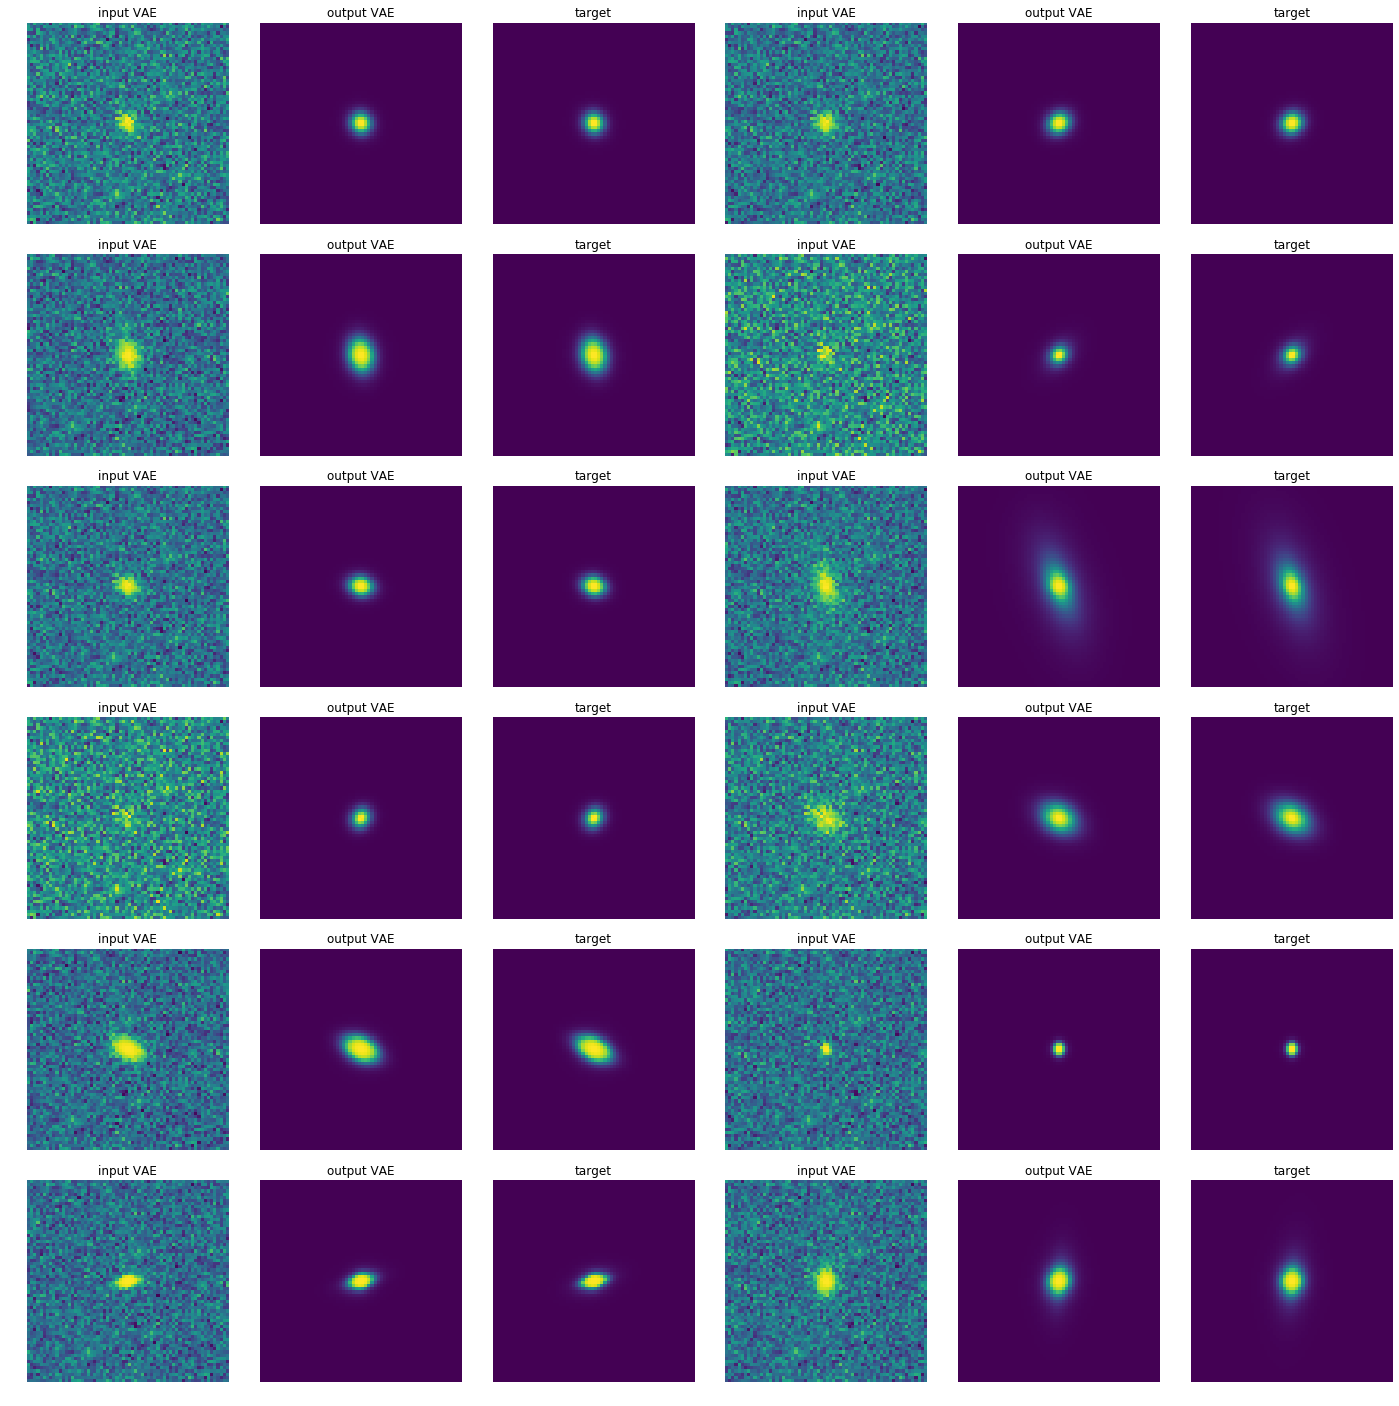

In [20]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        #print("image : "+str(i+j))
        input_vae = batch_gen.__getitem__(2)
        output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)
        axes[i,j].imshow(input_vae[0][indices[i*N_plot+j]])
        #print(np.max(input_vae[0][indices[i*N_plot+j]]))
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]])
        #print(np.max(output_vae[indices[i*N_plot+j]]))
        axes[i,j+2].imshow(input_vae[1][indices[i*N_plot+j]])
        #print(np.max(input_vae[1][indices[i*N_plot+j]]))
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

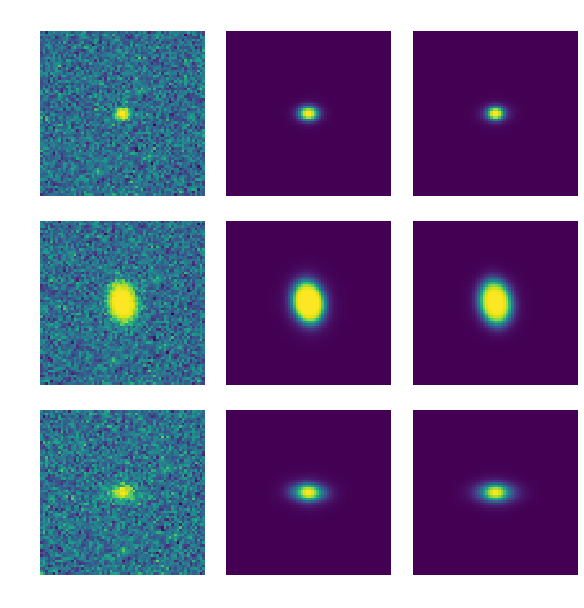

In [74]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(3, N_plot, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(3):
    for j in range(0,N_plot,3):
        #print("image : "+str(i+j))
        input_vae = batch_gen.__getitem__(2)
        output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)
        axes[i,j].imshow(input_vae[0][indices[i*N_plot+j]])
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]])
        axes[i,j+2].imshow(input_vae[1][indices[i*N_plot+j]])
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

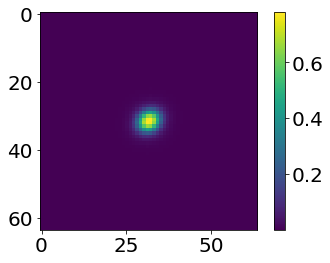

In [64]:
plt.imshow(input_vae[1][indices[3]])
plt.colorbar()

In [ ]:
plt.imshow(output_vae[indices[3]])
plt.colorbar()

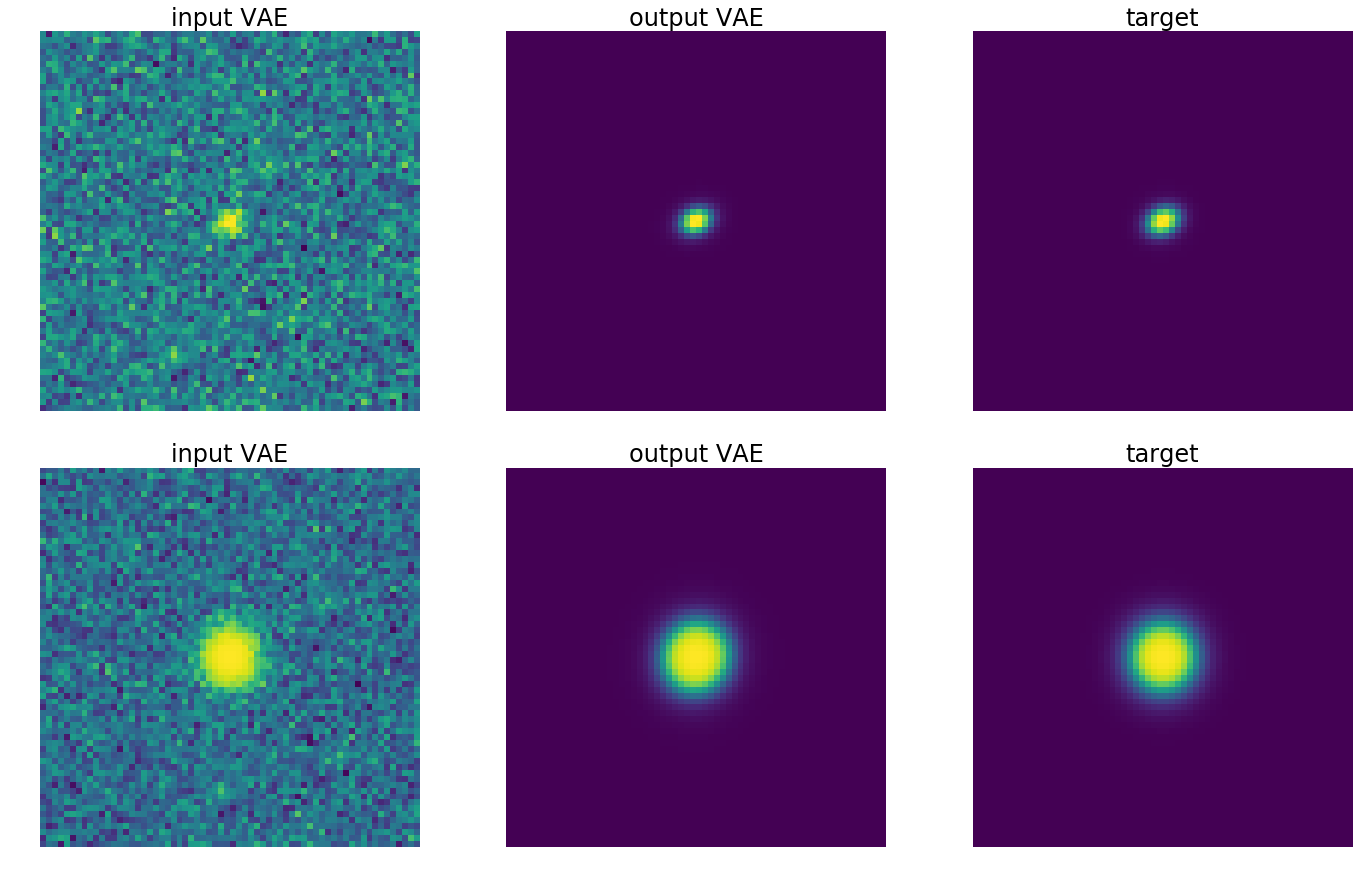

In [48]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)


N_plot = 3
fig, axes = plt.subplots(2, N_plot, figsize=(25, 15))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(2):
    for j in range(0,N_plot,3):
        input_vae = batch_gen.__getitem__(2)
        output_vae = vae_lsst_r_band_conv.predict(input_vae[0], batch_size = 100)
        axes[i,j].imshow(input_vae[0][indices[i*N_plot+j]])
        axes[i,j+1].imshow(output_vae[indices[i*N_plot+j]])
        axes[i,j+2].imshow(input_vae[1][indices[i*N_plot+j]])
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Test plot for LSST all filters

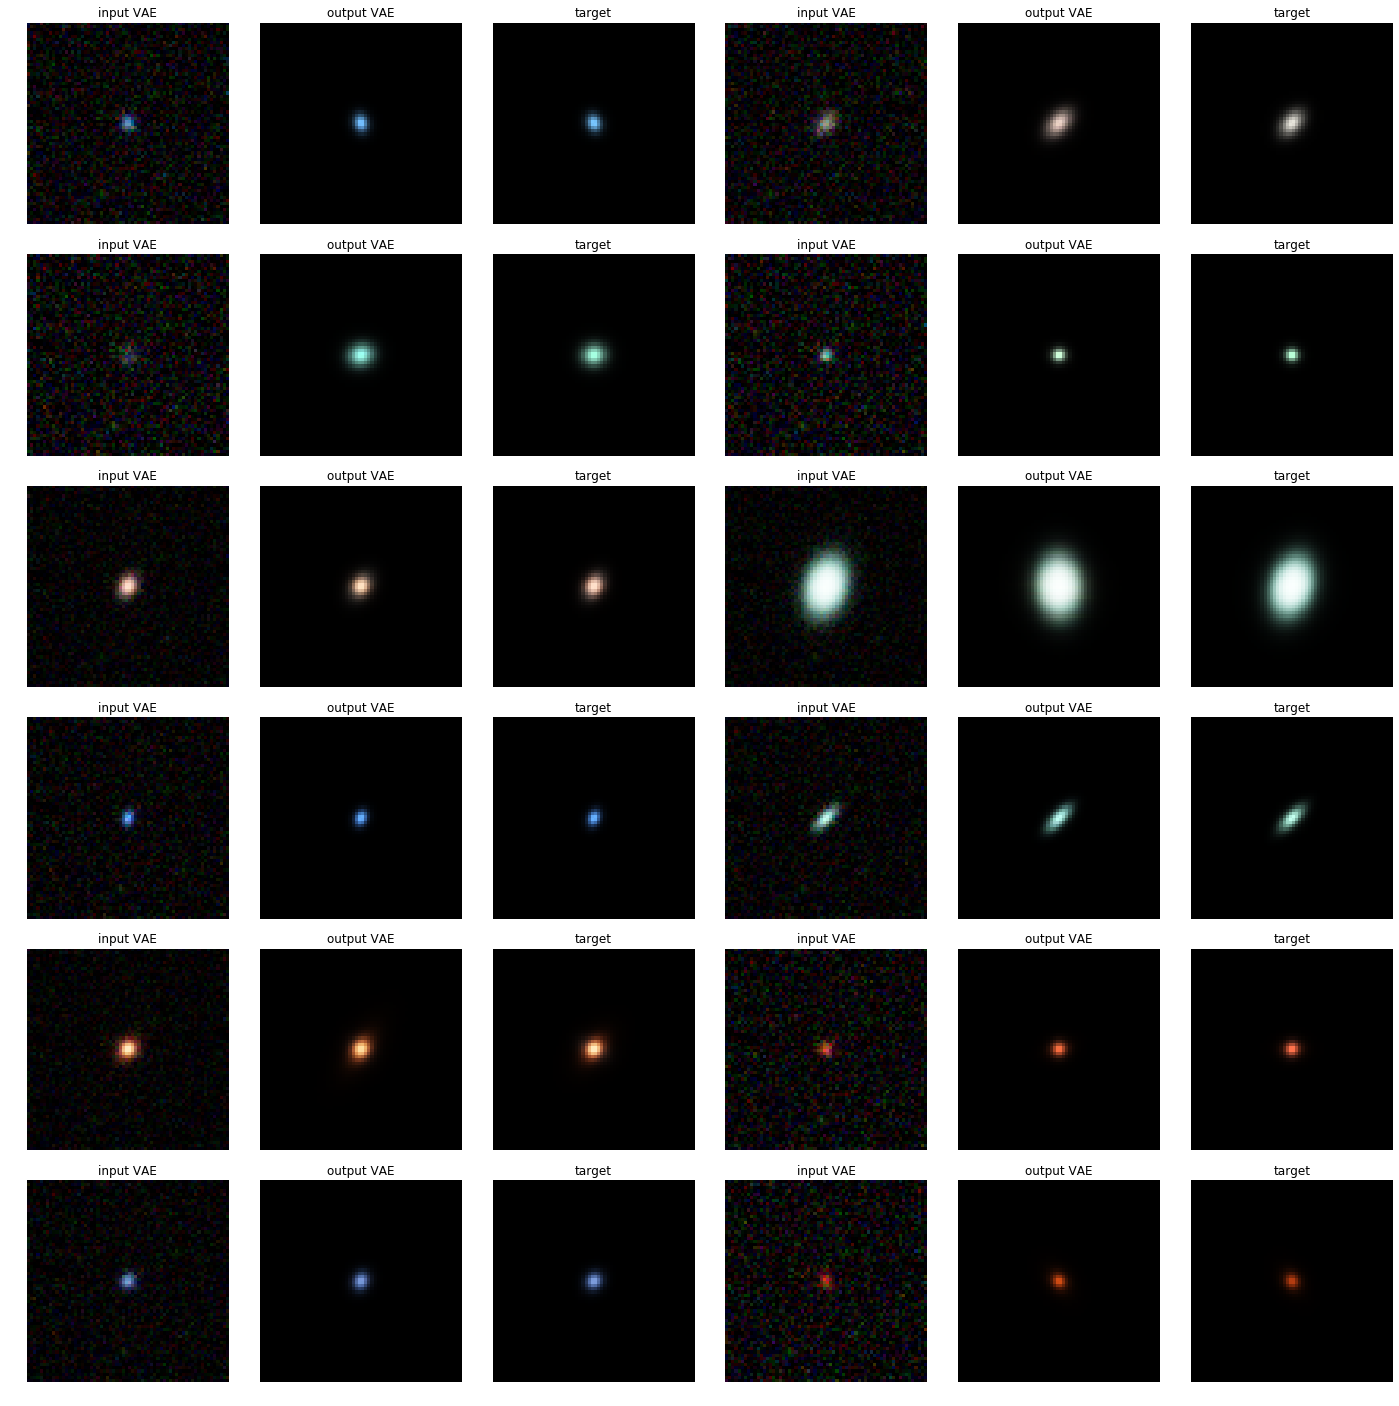

In [21]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        input_vae = batch_gen_lsst.__getitem__(2)
        output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)
        plot_rgb_lsst(input_vae[0][indices[i*N_plot+j]], axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], axes[i,j+1])
        plot_rgb_lsst(input_vae[1][indices[i*N_plot+j]], axes[i,j+2])
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


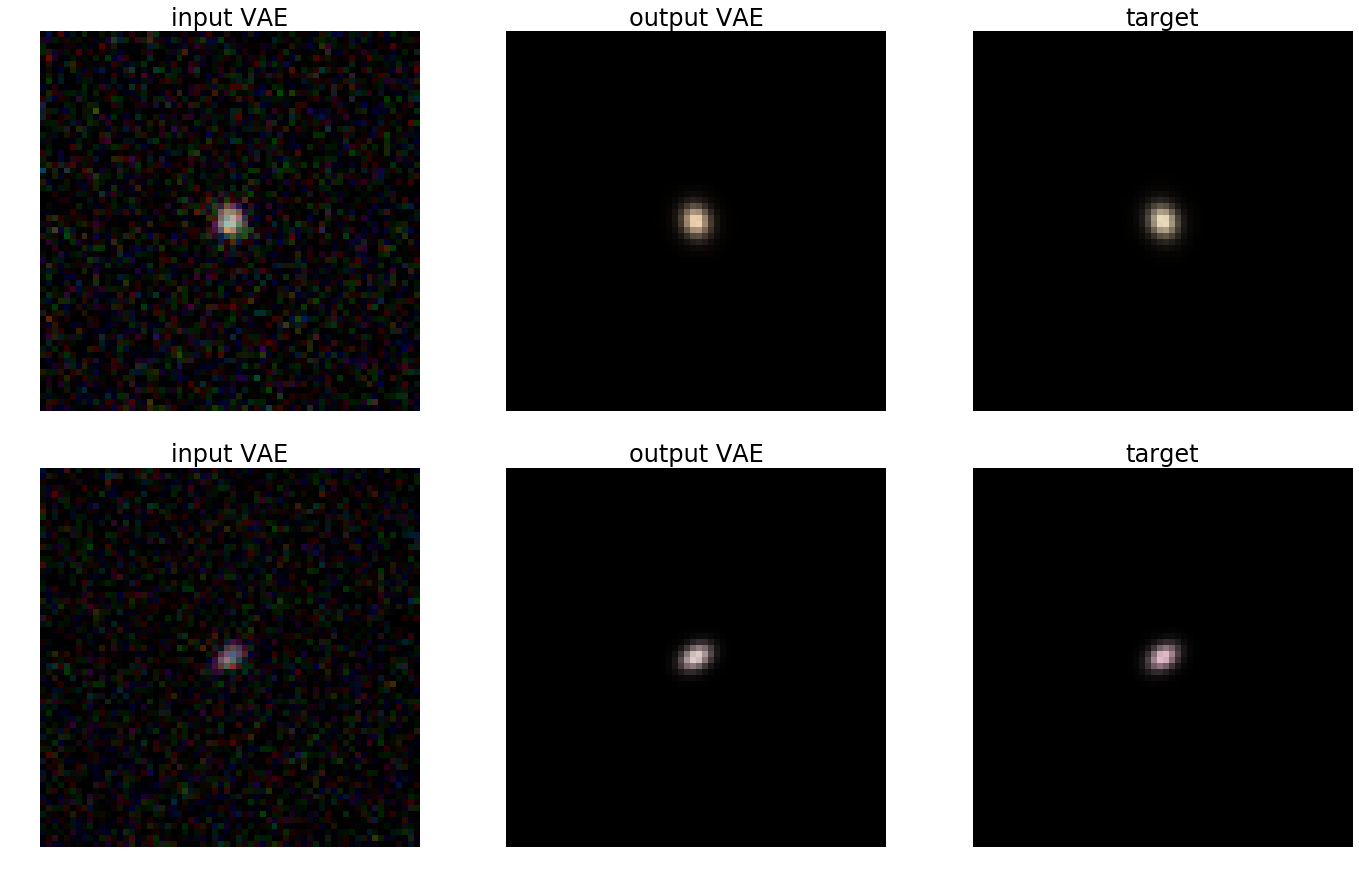

In [18]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

N_plot = 3
fig, axes = plt.subplots(2, 3, figsize=(25, 15))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(2):
    for j in range(0,N_plot,3):
        input_vae = batch_gen_lsst.__getitem__(2)
        output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)
        plot_rgb_lsst(input_vae[0][indices[i*N_plot+j]], axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], axes[i,j+1])
        plot_rgb_lsst(input_vae[1][indices[i*N_plot+j]], axes[i,j+2])
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

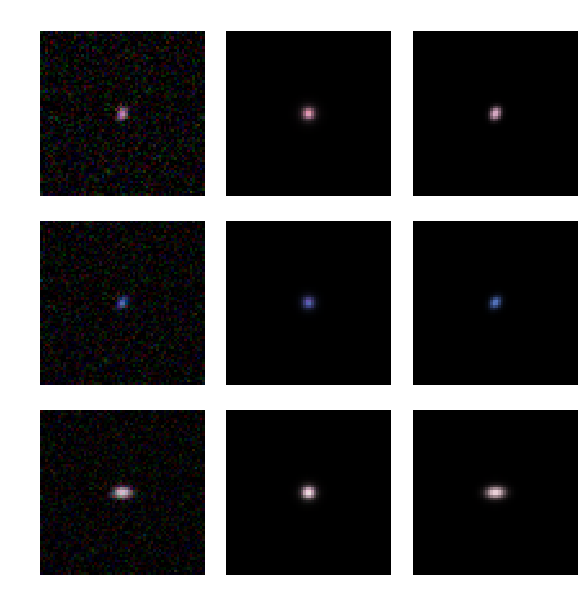

In [19]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

N_plot = 3
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(3):
    for j in range(0,N_plot,3):
        input_vae = batch_gen_lsst.__getitem__(2)
        output_vae = vae_lsst_conv.predict(input_vae[0], batch_size = 100)
        plot_rgb_lsst(input_vae[0][indices[i*N_plot+j]], axes[i,j])
        plot_rgb_lsst(output_vae[indices[i*N_plot+j]], axes[i,j+1])
        plot_rgb_lsst(input_vae[1][indices[i*N_plot+j]], axes[i,j+2])
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE', color = "w")
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE', color = "w")
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target', color = "w")

# Test plot for LSST + Euclid all filters

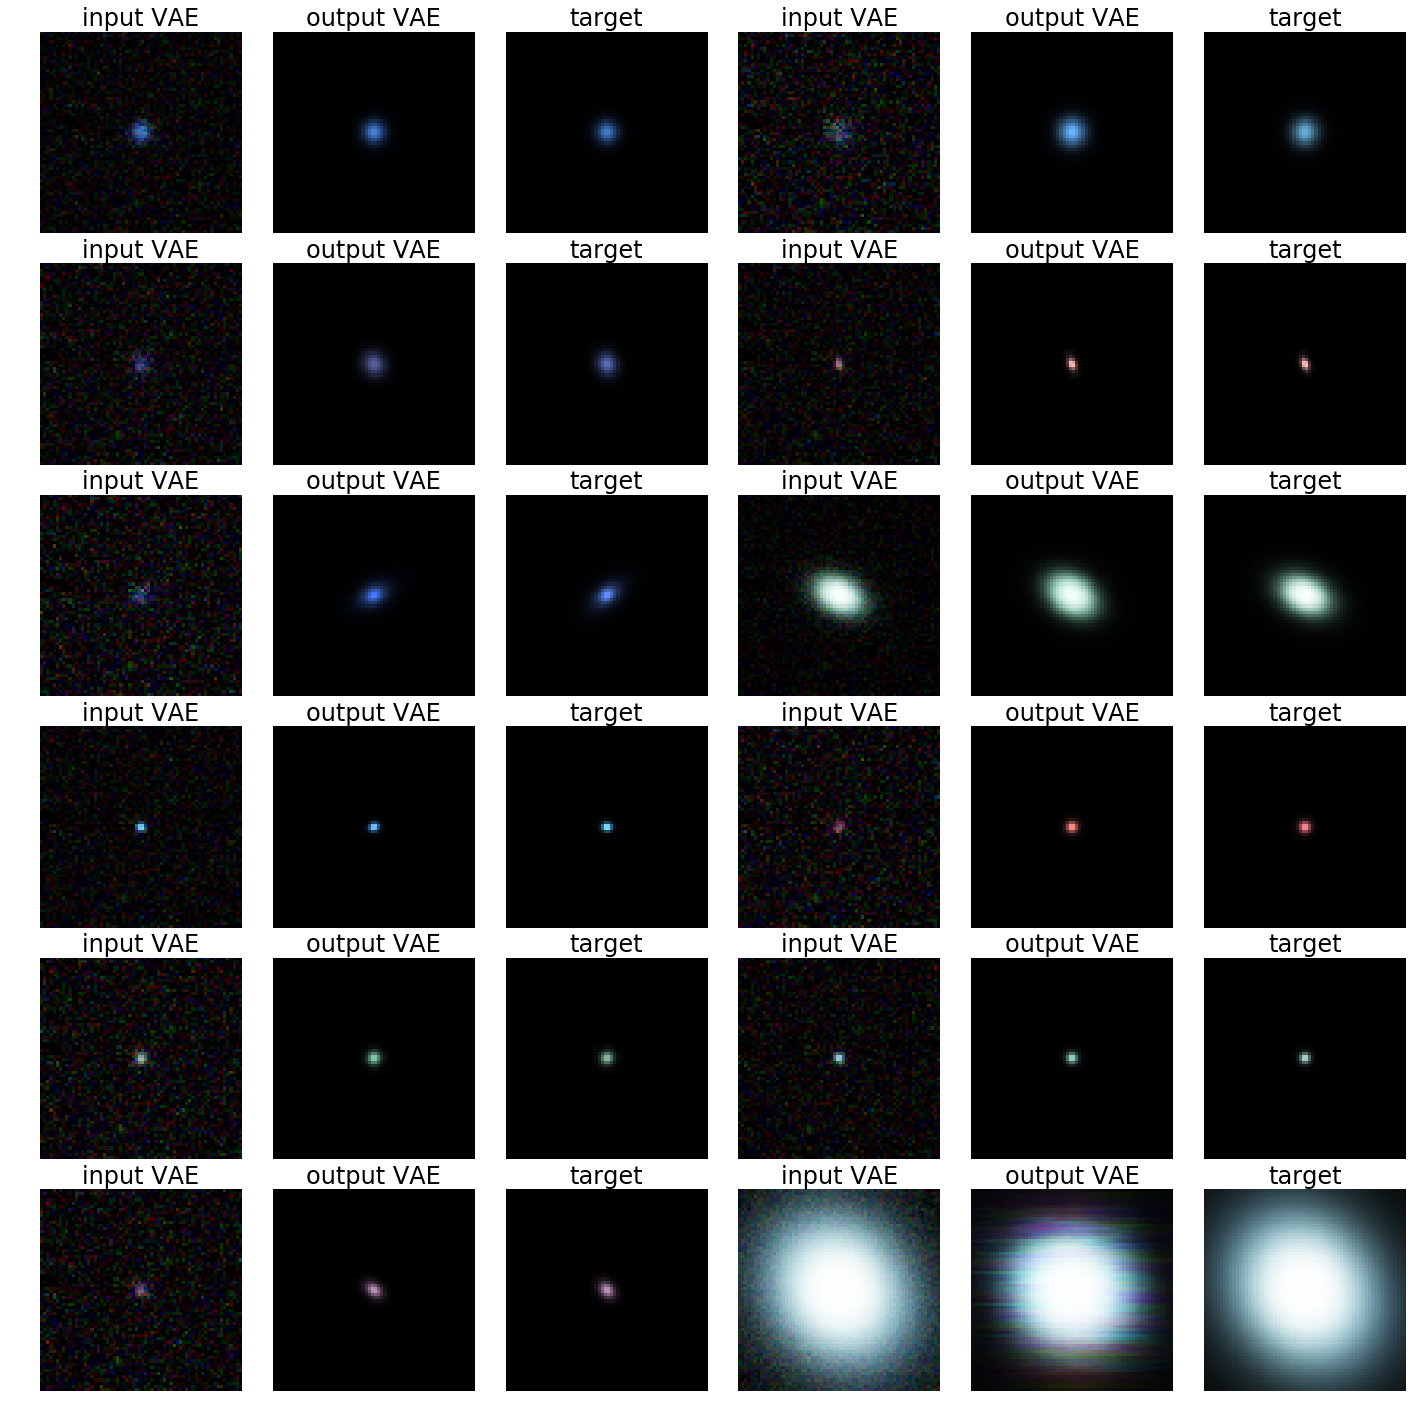

In [20]:
N_plot = 6
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        input_vae = batch_gen_lsst_euclid.__getitem__(2)
        output_vae = vae_lsst_euclid_conv.predict(input_vae[0], batch_size = 100)
        plot_rgb_lsst_euclid(input_vae[0][indices[i*N_plot+j]], axes[i,j])
        plot_rgb_lsst_euclid(output_vae[indices[i*N_plot+j]], axes[i,j+1])
        plot_rgb_lsst_euclid(input_vae[1][indices[i*N_plot+j]], axes[i,j+2])
        axes[i,j].axis('off')
        axes[i,j].set_title('input VAE')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output VAE')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Mask and Mean and variance computation functions

In [17]:
def mean_var(x,y,bins):

    n,_ = np.histogram(x,bins=bins, weights=None)
    ny,_ = np.histogram(x,bins=bins, weights=y)
    mean_y = ny/n
    ny2,_ = np.histogram(x,bins=bins, weights=y**2)
    var_y = (ny2/n - mean_y**2)/n
    
    return (mean_y, var_y)

In [18]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

## VAE LSST R band

In [167]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5

ellipticities = []
redshift_R=[]
e=[]

N = 100

lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')

for j in range(N):
    a = batch_gen.__getitem__(2)
    output_vae = vae_lsst_r_band_conv.predict(a[0], batch_size = batch_size)
    for i in range (len(a[0])):
        # Normalization: a[1][i] = np.tanh(np.arcsinh(a[1][i]/(I[6])))
        # Inverse the function
        a[1][i] = np.sinh(np.arctanh(a[1][i]))*(I[6]/beta)
        output_vae[i] = np.sinh(np.arctanh(output_vae[i]))*(I[6]/beta)
        try: 
            gal_image = galsim.Image(a[1][i])
            gal_image.scale = pix_scale

            # Measurements of shapes
            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            redshift_R.append(a[2])
            e.append([e_beta_in, e_beta_out])

            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = a[1][i].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple[j,i] = np.sum(masked_img_out_simple)
          
        except :
            print('erreur')
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
e_beta = np.array(e)

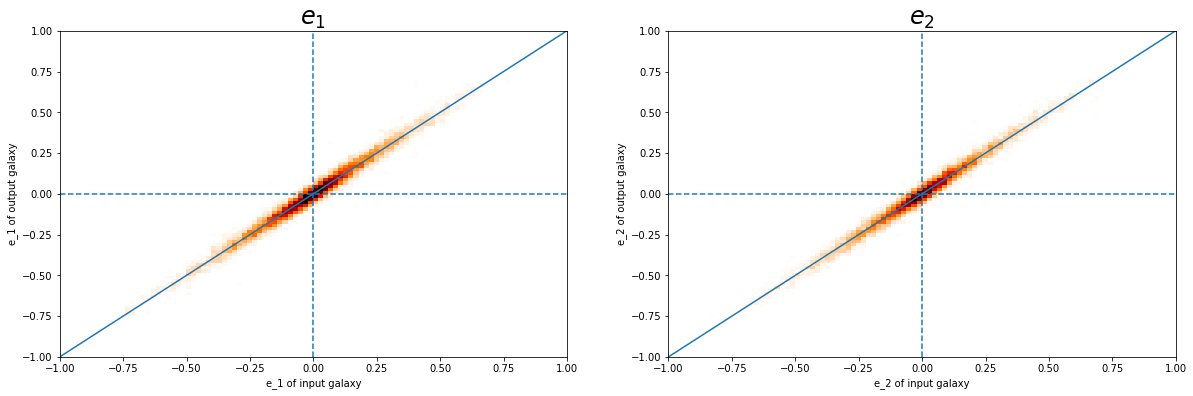

In [111]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

Text(0, 0.5, 'e of output galaxy')

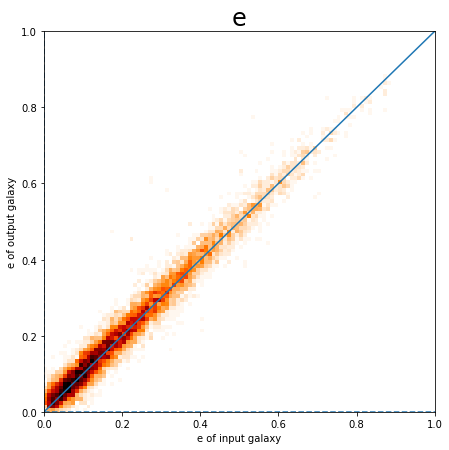

In [112]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta[:,0,0], e_beta[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

Text(0, 0.5, 'beta of output galaxy')

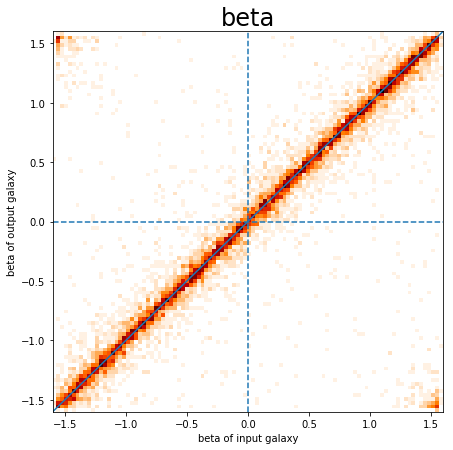

In [113]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta[:,0,1], e_beta[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

In [114]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

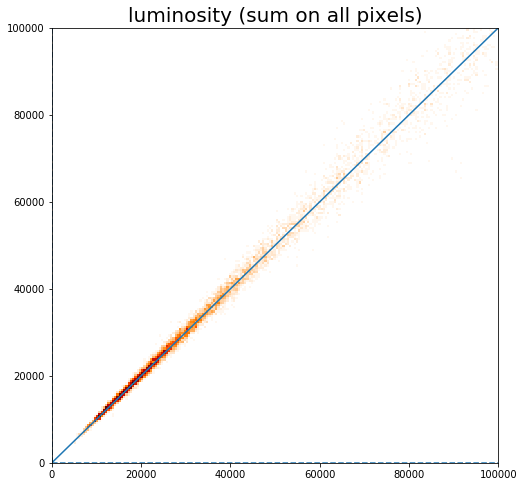

In [115]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 2000000)

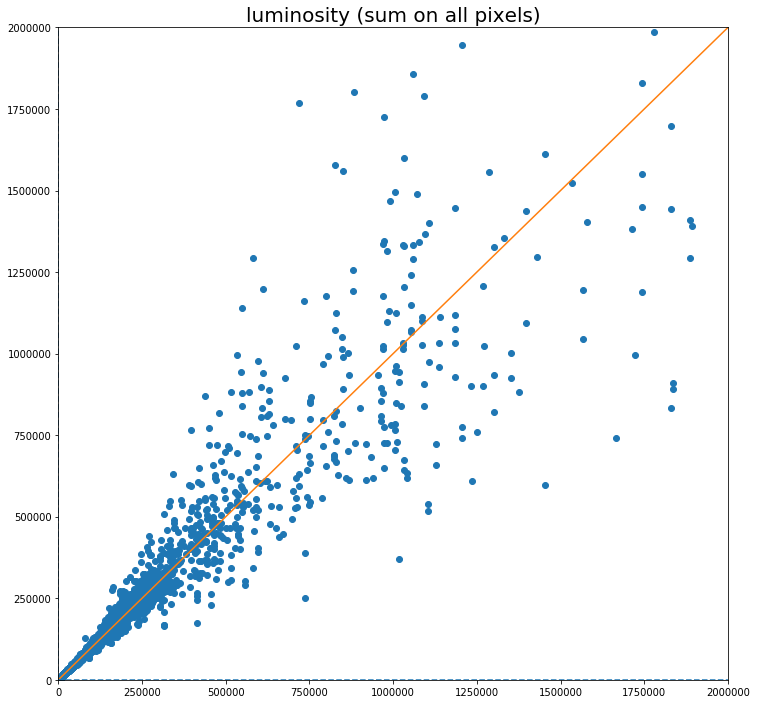

In [120]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 2000000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

(0, 200000)

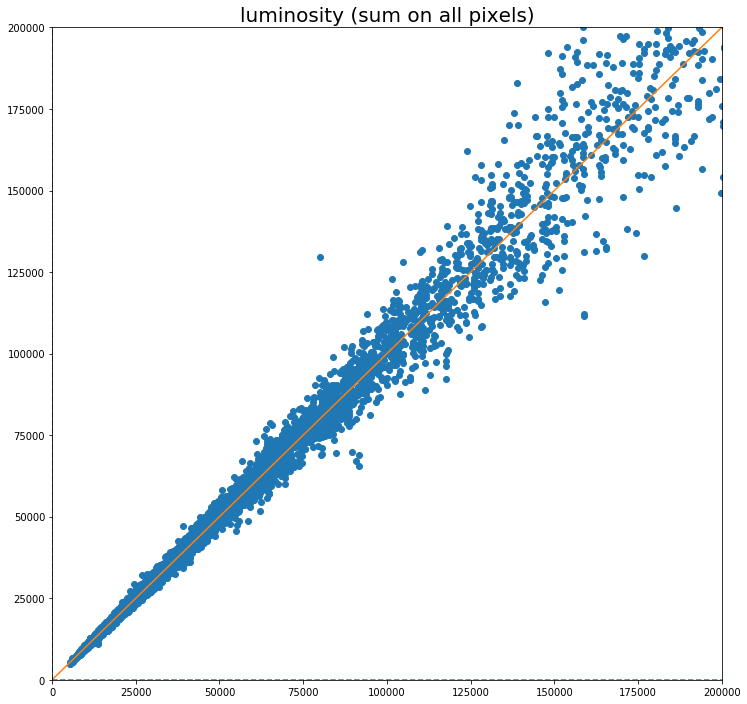

In [121]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

In [122]:
a = np.where(lum_in_simple[:]<100000)

In [123]:
len(a[0])

8294

In [124]:
ellipticities_r_band.shape

(10000, 2, 2)

In [125]:
test = np.delete(ellipticities_r_band, a[0], axis = 0)

In [126]:
test.shape

(1706, 2, 2)

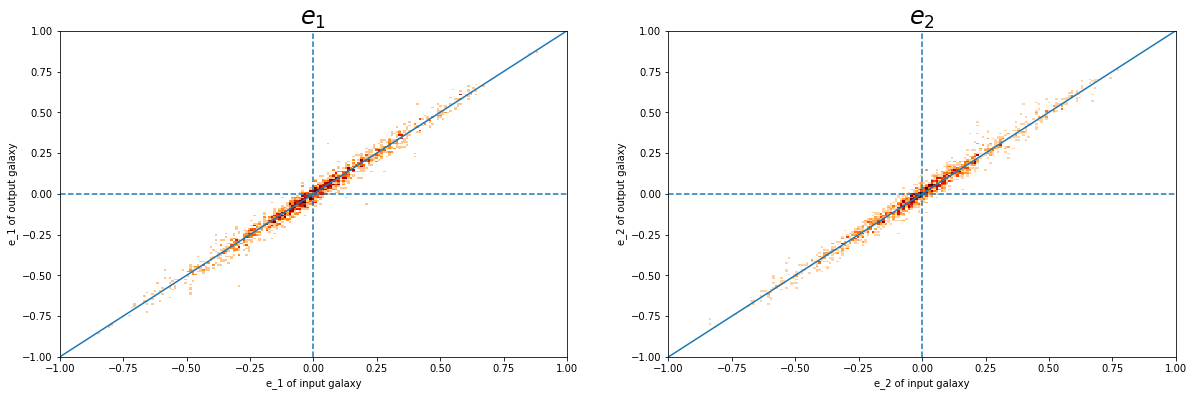

In [127]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(test[:,0,i], test[:,1,i], bins=np.linspace(-emax,+emax,200), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

In [128]:
import seaborn as sns

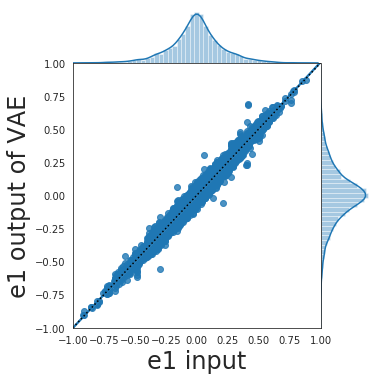

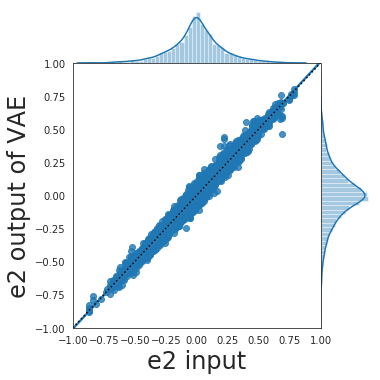

In [129]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

In [130]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

Text(0, 0.5, 'delta_e1')

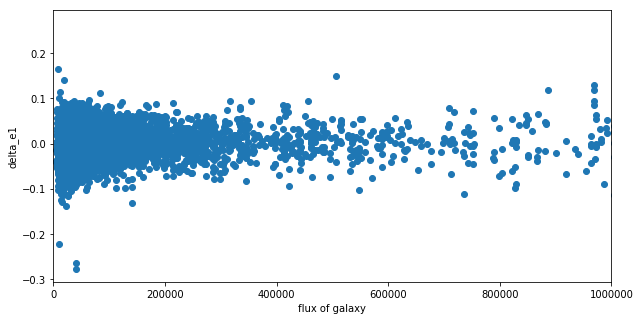

In [131]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple, delta_e1, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e1')

Text(0, 0.5, 'delta_e2')

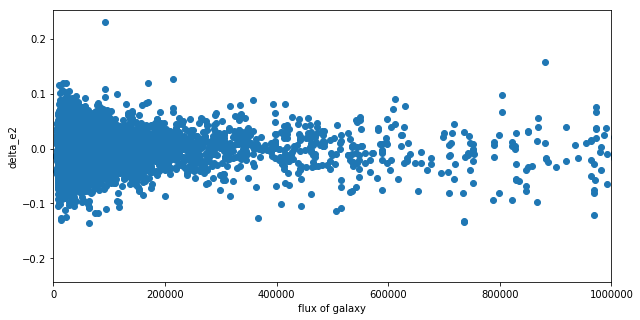

In [134]:
fig = plt.subplots(1,1, figsize=(10,5))
plt.plot(lum_in_simple, delta_e2, 'o')
plt.xlim(0,1000000)
plt.xlabel('flux of galaxy')
plt.ylabel('delta_e2')

In [35]:
galaxies = np.load('/sps/lsst/users/barcelin/data/single/v7/galaxies_COSMOS_test_v3.npy')

In [46]:
len(galaxies)

10000

In [41]:
lum_in_simple_gal = np.empty([10000,],dtype='float32')

for i in range (len(galaxies)):
    # Measurement of fluxes
    mask = createCircularMask(64,64,None,5)
    masked_img_in_simple = galaxies[i][0][6].copy()
    masked_img_in_simple[~mask] = 0  

    # Calculate the luminosity by substracting the noise
    lum_in_simple_gal[i] = np.sum(masked_img_in_simple)
    

10393813.0


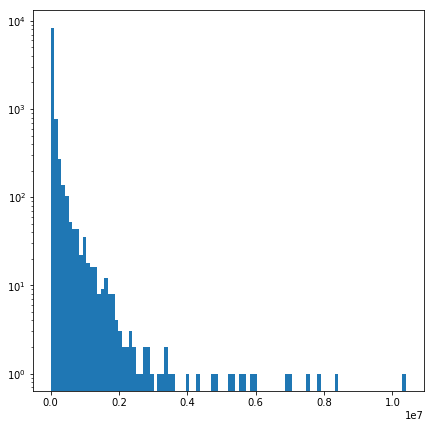

In [69]:
fig = plt.subplots(1,1,figsize=(7,7))
_ = plt.hist(lum_in_simple_gal, bins = 100, log = True)

print(np.max(lum_in_simple_gal))

In [59]:
gal_large_f_coord = np.where(lum_in_simple_gal<4000000)

In [60]:
len(gal_large_f_coord[0])

9984

In [61]:
gal_large_f = np.delete(galaxies, gal_large_f_coord[0], axis = 0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


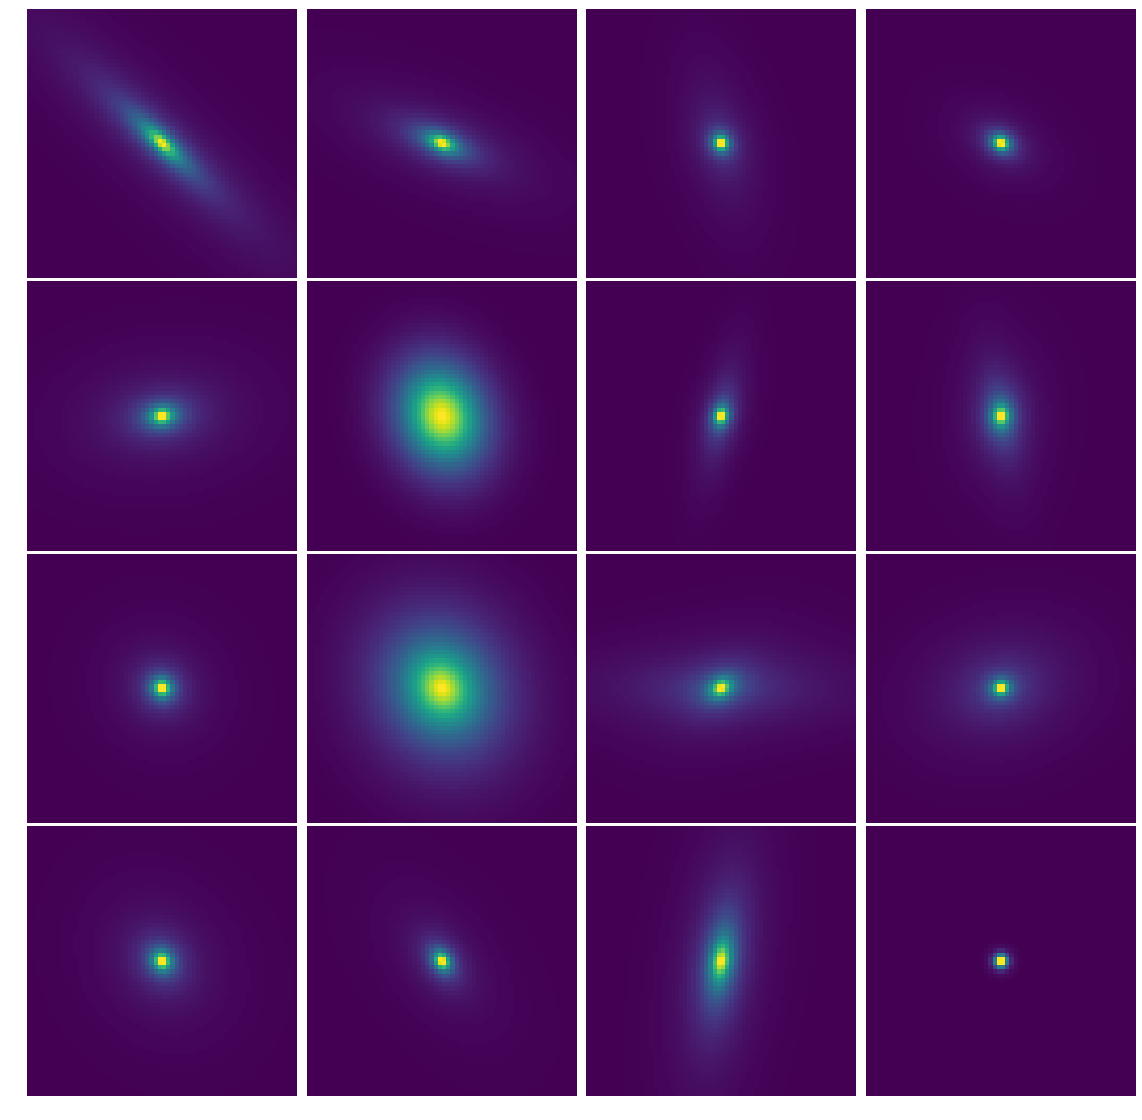

In [62]:
N_plot = 4
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        print(i*N_plot+j)
        axes[i,j].imshow(gal_large_f[i*N_plot+j][0][3])
        axes[i,j].axis('off')

#### de Deblender_VAE sur petit échantillon

In [55]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5

ellipticities = []
redshift_R=[]
e=[]

N = 100

lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')

for j in range(N):
    a = batch_gen.__getitem__(2)
    output_vae = vae_lsst_r_band_conv.predict(a[0], batch_size = batch_size)
    for i in range (len(a[0])):
        # Normalization: a[1][i] = np.tanh(np.arcsinh(a[1][i]/(I[6])))
        # Inverse the function
        a[1][i] = np.sinh(np.arctanh(a[1][i]))*(I[6]/beta)
        output_vae[i] = np.sinh(np.arctanh(output_vae[i]))*(I[6]/beta)
        try: 
            gal_image = galsim.Image(a[1][i])
            gal_image.scale = pix_scale

            # Measurements of shapes
            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            redshift_R.append(a[2])
            e.append([e_beta_in, e_beta_out])

            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = a[1][i].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple[j,i] = np.sum(masked_img_out_simple)
          
        except :
            print('erreur')
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
e_beta = np.array(e)

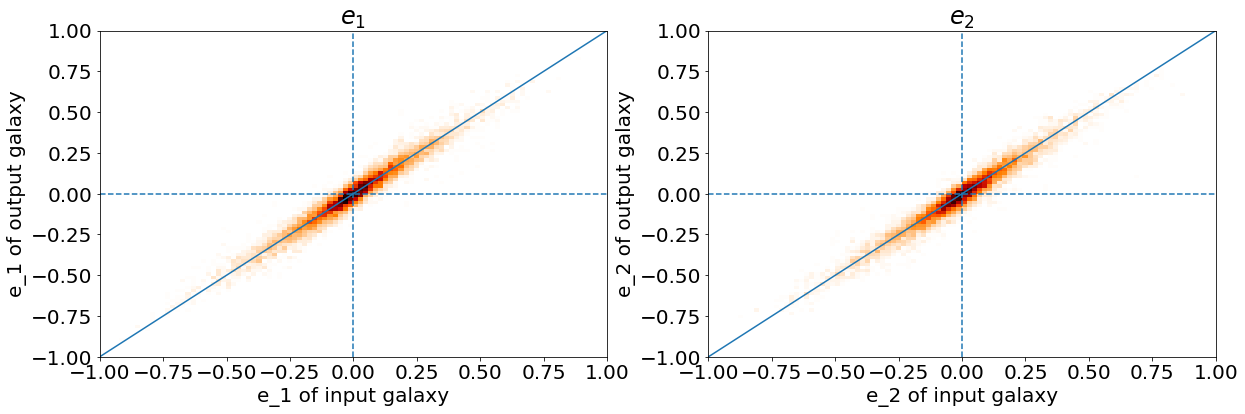

In [56]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

In [57]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

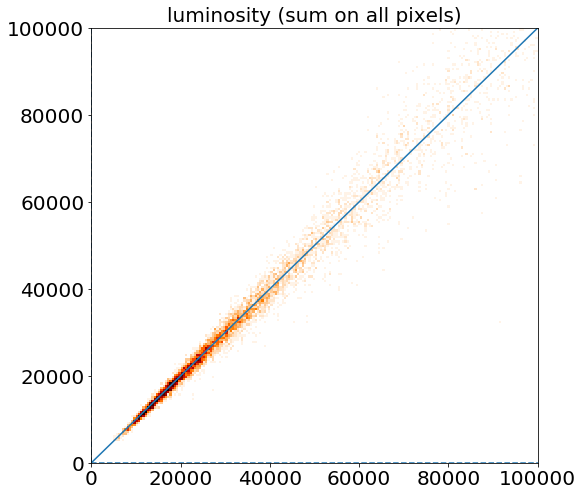

In [58]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 200000)

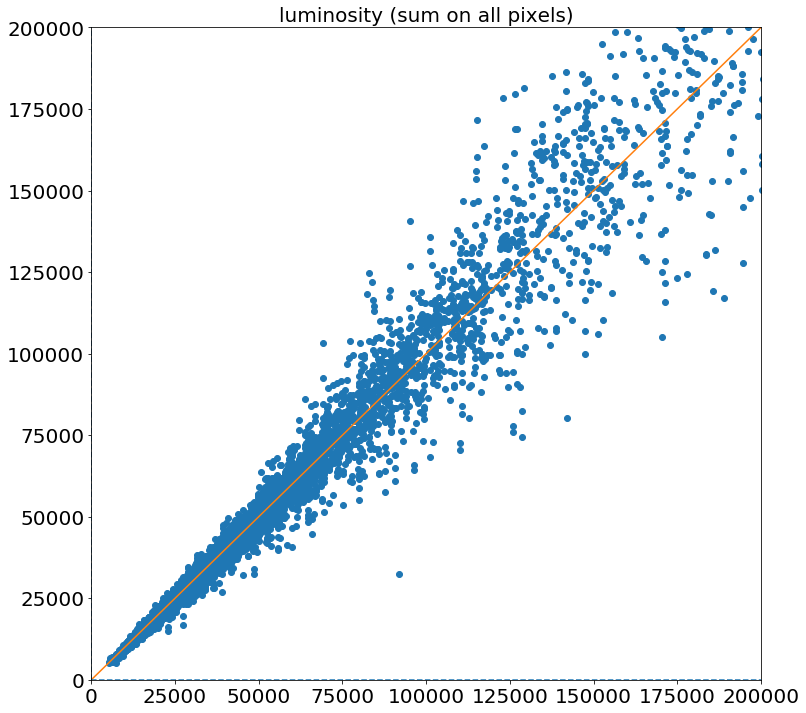

In [59]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

In [20]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
beta = 5

ellipticities = []
redshift_R=[]
e=[]

N = 100

lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')

for j in range(N):
    a = batch_gen.__getitem__(2)
    output_vae = vae_lsst_r_band_conv_64.predict(a[0], batch_size = batch_size)
    for i in range (len(a[0])):
        # Normalization: a[1][i] = np.tanh(np.arcsinh(a[1][i]/(I[6])))
        # Inverse the function
        a[1][i] = np.sinh(np.arctanh(a[1][i]))*(I[6]/beta)
        output_vae[i] = np.sinh(np.arctanh(output_vae[i]))*(I[6]/beta)
        try: 
            gal_image = galsim.Image(a[1][i])
            gal_image.scale = pix_scale

            # Measurements of shapes
            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            redshift_R.append(a[2])
            e.append([e_beta_in, e_beta_out])

            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = a[1][i].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple[j,i] = np.sum(masked_img_in_simple)
            lum_out_simple[j,i] = np.sum(masked_img_out_simple)
          
        except :
            print('erreur')
            pass
        continue

ellipticities_r_band_2 = np.array(ellipticities)
e_beta = np.array(e)

InvalidArgumentError: Incompatible shapes: [100,10] vs. [100,64]
	 [[{{node lambda_1/mul}}]]

In [ ]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(20,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=24)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    axes[i].set_xlabel('e_'+str(i+1)+' of input galaxy')
    axes[i].set_ylabel('e_'+str(i+1)+' of output galaxy')

Text(0, 0.5, 'e of output galaxy')

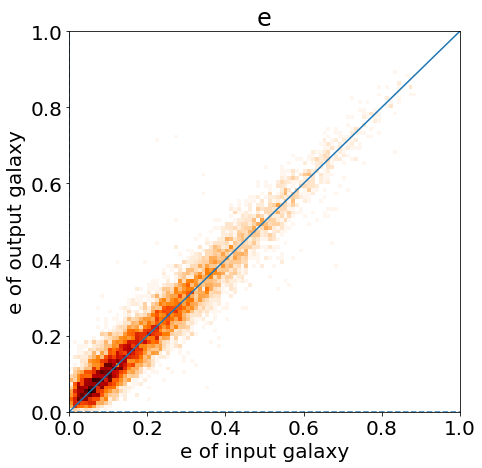

In [190]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta[:,0,0], e_beta[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

In [164]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

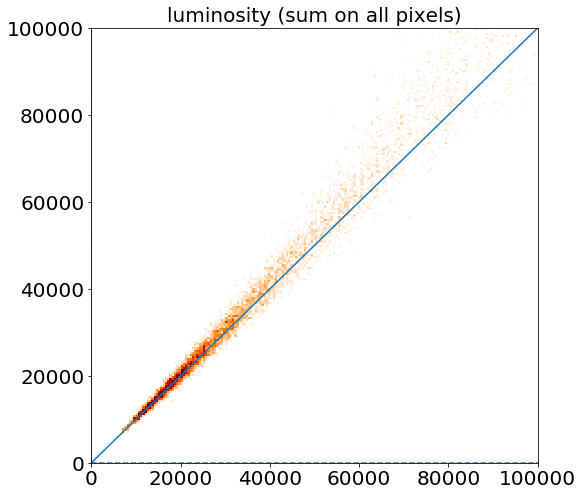

In [165]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 200000)

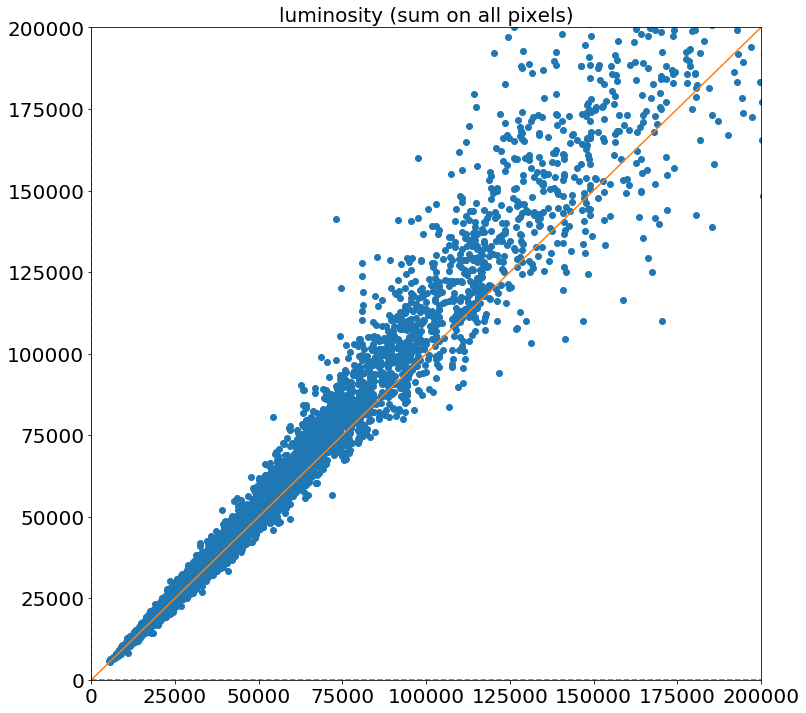

In [166]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 200000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


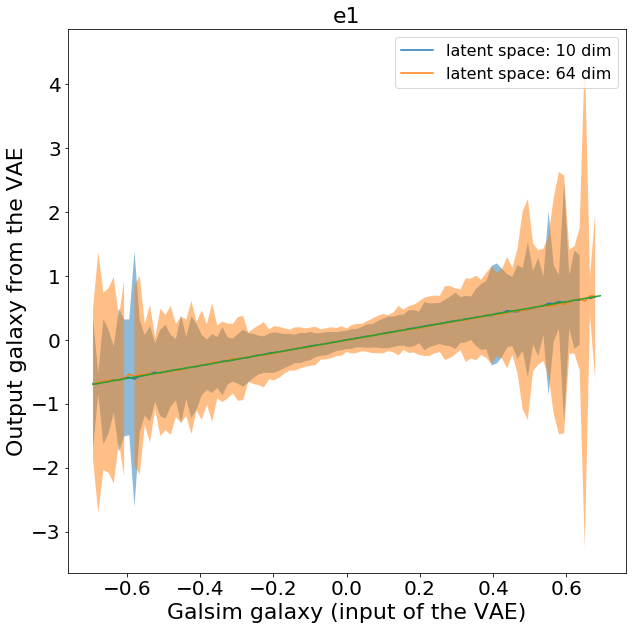

In [169]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,0],ellipticities_r_band[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_r_band_2[:,0,0],ellipticities_r_band_2[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'latent space: 10 dim')
plt.plot(mid, mean_multi, label = 'latent space: 64 dim')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

plt.plot(mid, mid)

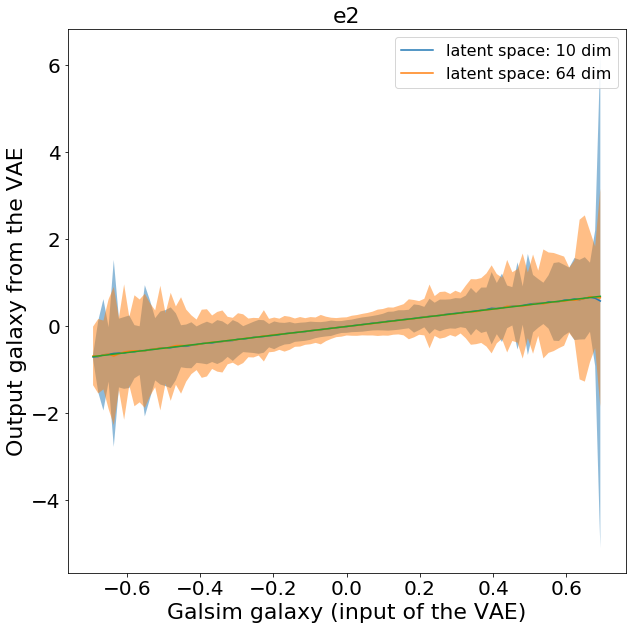

In [171]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,1],ellipticities_r_band[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_r_band_2[:,0,1],ellipticities_r_band_2[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'latent space: 10 dim')
plt.plot(mid, mean_multi, label = 'latent space: 64 dim')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)

plt.plot(mid, mid)

### Corner plot latent space

In [172]:
batch_size = 100

In [173]:
def plot_corner_latent(z, lim=3, nbins=25, show_title=True):
    """
    Make a corner plot of standard gaussian distributed latent variables.
    Parameters
    ----------
    z : latent variables, array of size (n_samples, latent_dim)
    lim : int, optional
        [description], by default 3
    nbins : int, optional
        [description], by default 25
    show_title : bool, optional
        [description], by default True
    Example
    -------
    z = np.random.normal(size=(1000,8))
    plot_corner_latent(z)
    """

    import matplotlib as mpl
    from mpl_toolkits.axes_grid1 import Grid
    
    latent_dim = z.shape[1]
    
    fig = plt.figure(figsize=(latent_dim*2,latent_dim*2))
    grid = Grid(fig, rect=111, nrows_ncols=(latent_dim,latent_dim), axes_pad=0.25, label_mode='L', share_y=False)
    
    colors = mpl.cm.jet(np.linspace(0,1,latent_dim))
    bins = np.linspace(-lim,+lim,nbins)
    
    for i in range(latent_dim):
        for j in range(latent_dim):
            ax = grid[i*latent_dim+j]
            if i == j :
                n,_,_ = ax.hist(z[:,i], bins=bins, normed=True, color=colors[i])
                ax.set_yticks([])
                if show_title:
                    ax.set_title('$z_{}$'.format(i))
            if i > j :
                ax.hist2d(z[:,j], z[:,i], bins=bins, cmap=mpl.cm.gray)
            if i < j :
                ax.axis('off')
    
    plt.tight_layout()
    
    return fig



In [174]:
a = batch_gen.__getitem__(2)
output_enc = encoder_R.predict(a[0], batch_size = batch_size)

In [175]:
output_enc[0].shape

(100, 10)

In [183]:
latent_dim =10
epsilon_std = 1.0

In [184]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon

In [185]:
z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder_R.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))


ValueError: operands could not be broadcast together with shapes (100,10) (100,64) 

In [186]:
len(z)

0

In [180]:
z = np.concatenate(z, axis = 0)

In [181]:
len(z)

10000

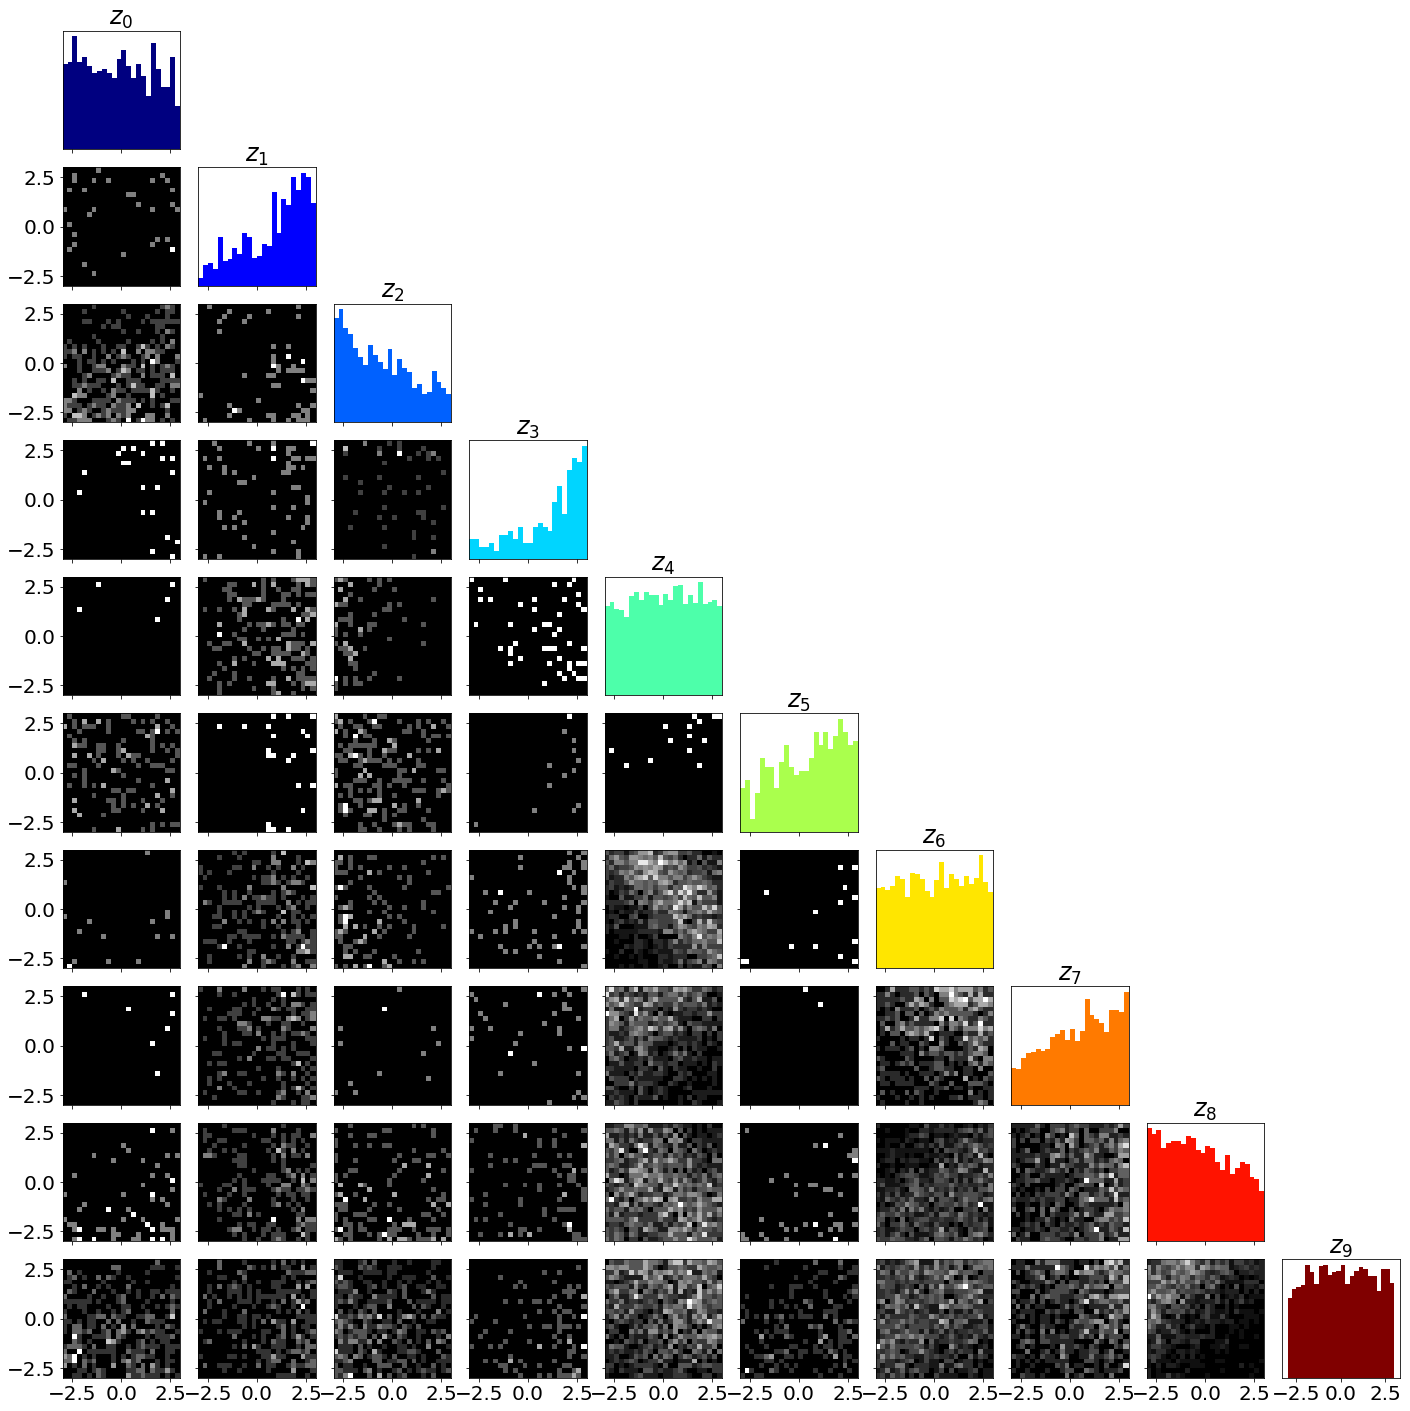

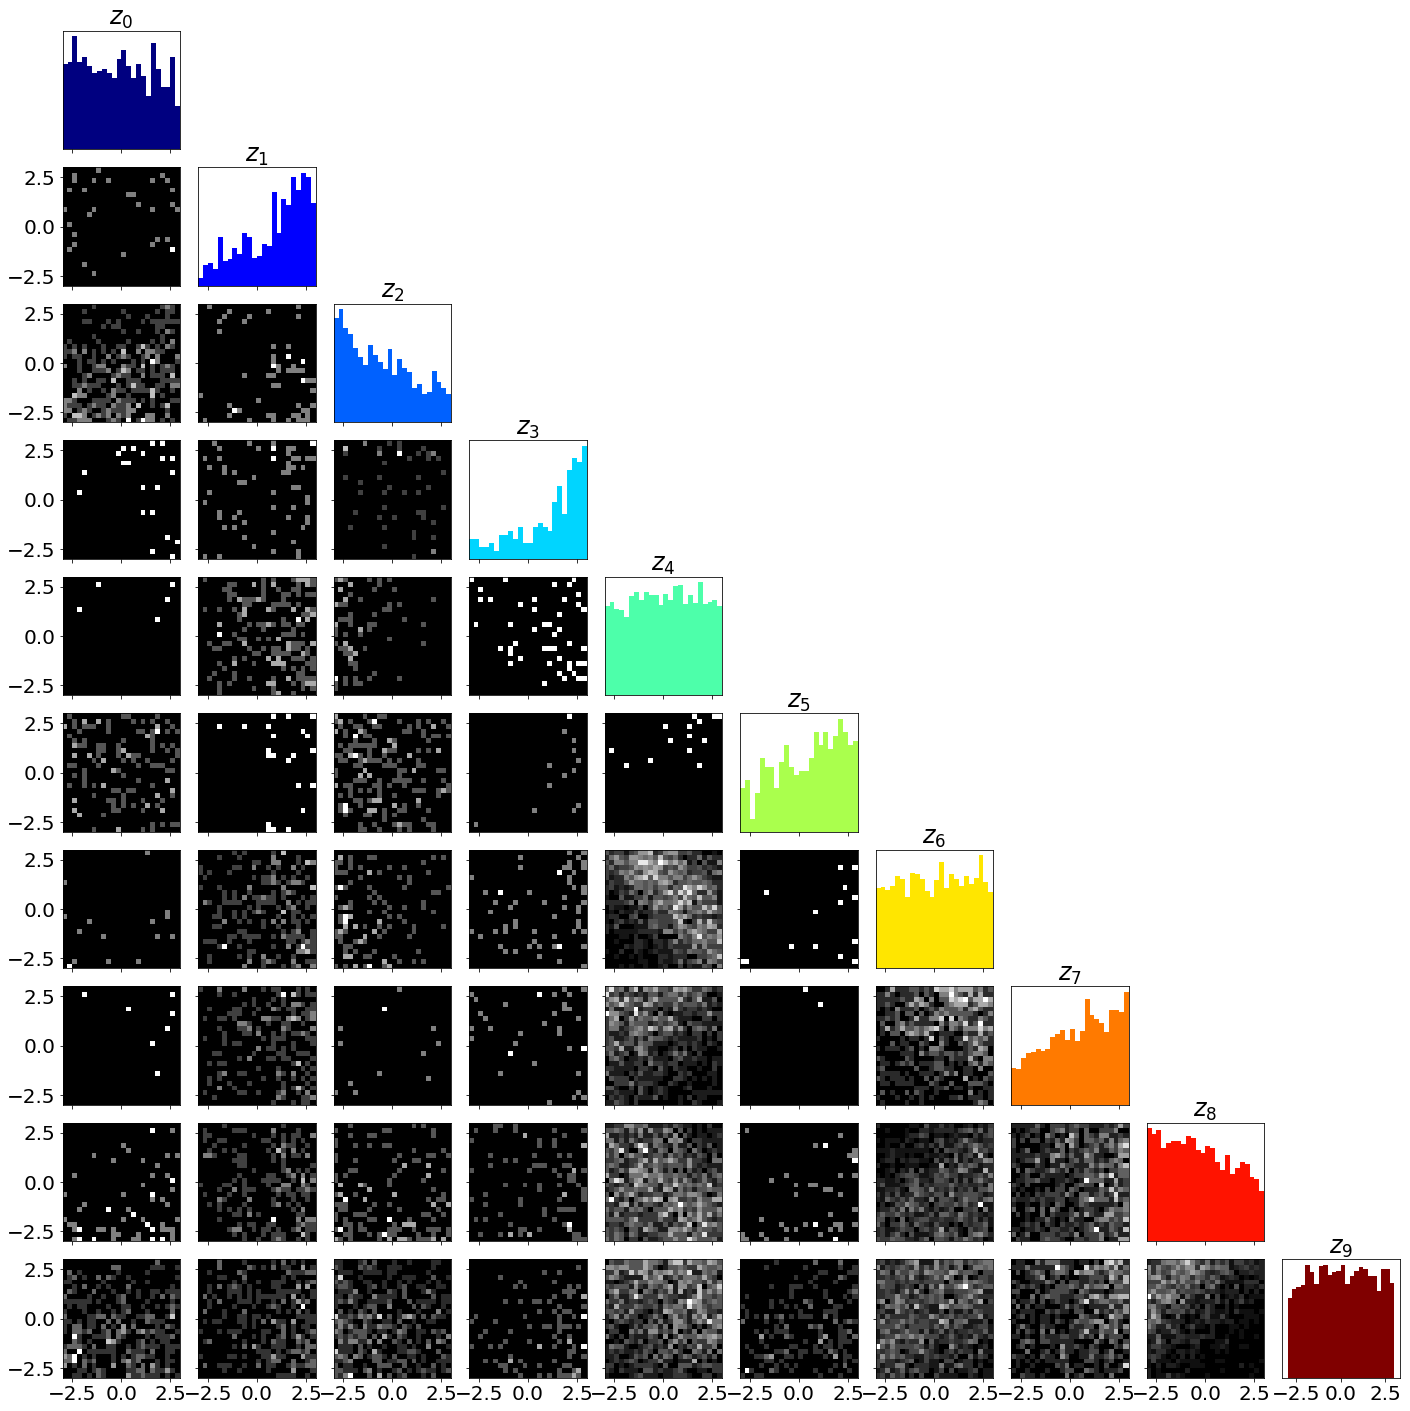

In [182]:
plot_corner_latent(z)

## LSST all filters

In [36]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]

ellipticities = []
redshift_LSST=[]
e=[]
counts = 0
for j in range(100):
    a = batch_gen_lsst.__getitem__(2)
    output_vae = vae_lsst_conv.predict(a[0], batch_size = batch_size)
    for i in range (len(a[0])):
        try:
            # Normalization: a[0][i] = np.tanh(np.arcsinh(a[0][i]/(I[6])))
            # Inverse the function
            #for j in range (6):
            #    a[1][i][:,:,j] = np.sinh(np.arctanh(a[1][i][:,:,j]))*(I[j+4])
            #    output_vae[i][:,:,j] = np.sinh(np.arctanh(output_vae[i][:,:,j]))*(I[j+4])

            gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]
            e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

            gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]
            e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

            ellipticities.append([e_in, e_out])
            redshift_LSST.append(a[2])
            e.append([e_beta_in, e_beta_out])
        except :
            print('erreur')
            counts+=1
            pass
        continue

ellipticities = np.array(ellipticities)
e_beta = np.array(e)
print('number of errors: '+str(counts))

erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
number of errors: 12


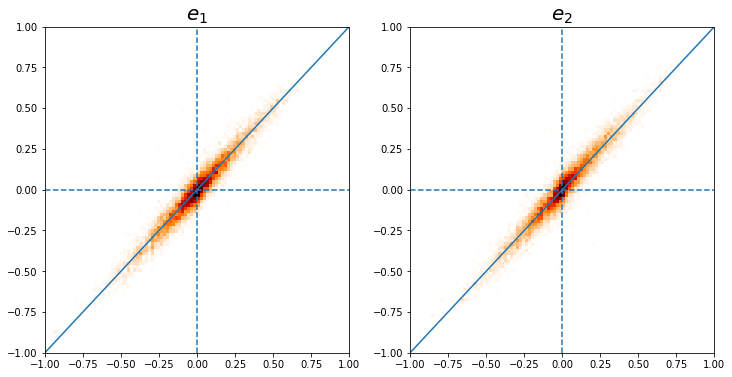

In [37]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities[:,0,i], ellipticities[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), fontsize=20)
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')
    axes[i].tick_params(axis='y')

Text(0, 0.5, 'e of output galaxy')

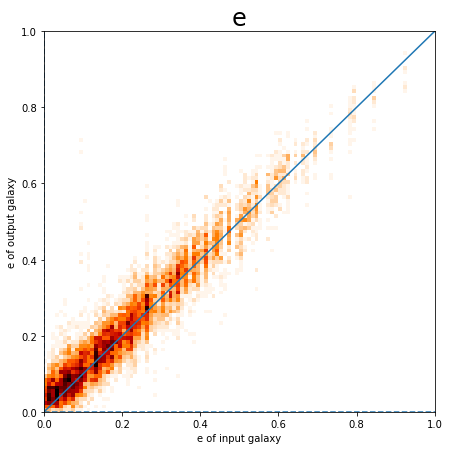

In [38]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1
_ = plt.hist2d(e_beta[:,0,0], e_beta[:,1,0], bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([0,+emax],[0,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('e'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('e of input galaxy')
plt.ylabel('e of output galaxy')

Text(0, 0.5, 'beta of output galaxy')

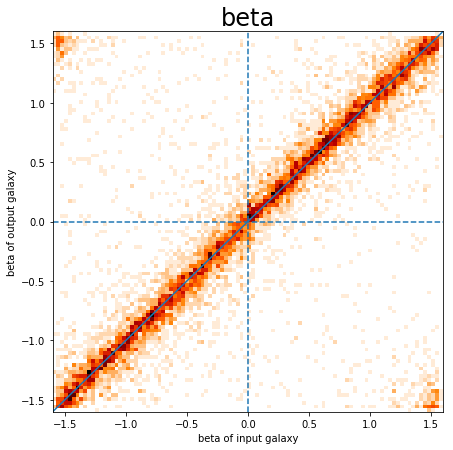

In [39]:
fig = plt.subplots(1,1, figsize=(7,7))
emax = 1.6
_ = plt.hist2d(e_beta[:,0,1], e_beta[:,1,1], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
plt.plot([-emax,+emax],[-emax,+emax])
plt.axhline(y=0, ls='--')
plt.axvline(x=0, ls='--')
plt.title('beta'.format(i+1),fontsize=24)# color="w", 
#plt.xaxis.label#.set_color('w')
plt.tick_params(axis='x')#, colors='w'
plt.tick_params(axis='y')#, colors='w'
plt.xlabel('beta of input galaxy')
plt.ylabel('beta of output galaxy')

## LSST + Euclid all filters

In [23]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities_LSST_euclid = []
redshift_LSST_euclid=[]
for j in range(100):
    a = batch_gen_lsst_euclid.__getitem__(2)
    output_vae = vae_lsst_euclid_conv.predict(a[0], batch_size = batch_size)
    for i in range (len(a[0])):
        try: 
            gal_image = galsim.Image(a[1][i].reshape((10,64,64))[6])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]

            gal_image = galsim.Image(output_vae[i].reshape((10,64,64))[6])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]

            ellipticities_LSST_euclid.append([e_in, e_out])
            redshift_LSST_euclid.append(a[2])
        except :
            print('erreur')
            pass
        continue

erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur
erreur


In [24]:
ellipticities_LSST_euclid = np.array(ellipticities_LSST_euclid)

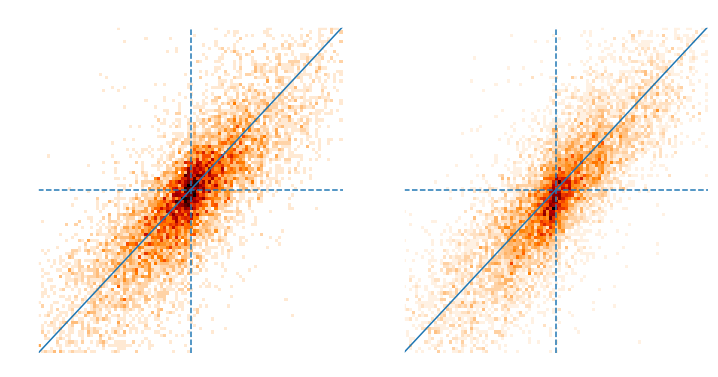

In [25]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 0.5
for i in range(2):
    _ = axes[i].hist2d(ellipticities_LSST_euclid[:,0,i], ellipticities_LSST_euclid[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1), color="w", fontsize=20)
    axes[i].spines['bottom'].set_color('w')
    axes[i].spines['right'].set_color('w')
    axes[i].spines['left'].set_color('w')
    axes[i].spines['top'].set_color('w')
    axes[i].xaxis.label.set_color('w')
    axes[i].tick_params(axis='x', colors='w')
    axes[i].tick_params(axis='y', colors='w')

### Reproduction as function of redshift

#### LSST R band

In [19]:
# R band
error_R_e1 = ellipticities_r_band[:,0,0] - ellipticities_r_band[:,1,0]
error_R_e2 = ellipticities_r_band[:,0,1] - ellipticities_r_band[:,1,1]

redshift = np.zeros((len(redshift_R)))
for i in range (len(redshift_R)):
    redshift[i] = redshift_R[i][0]

In [22]:
ellipticities_r_band[:,0,0].shape, ellipticities_r_band[:,1,0].shape


((9972,), (9972,))

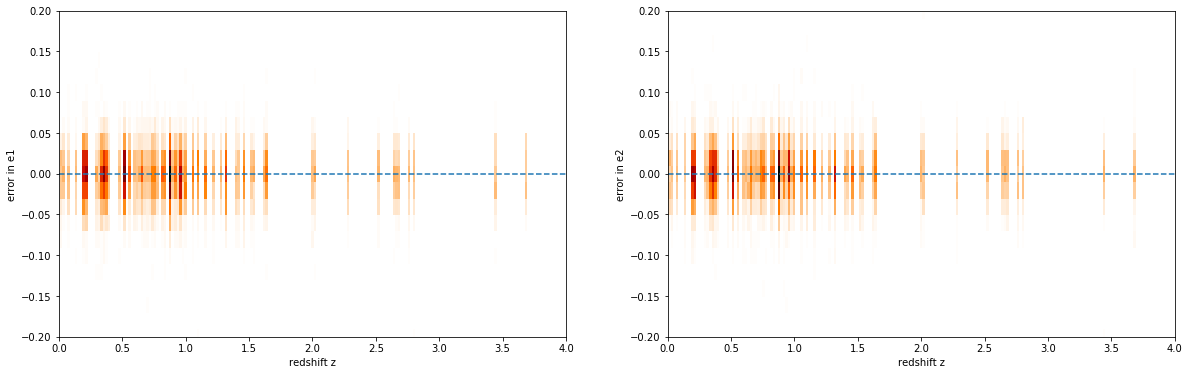

In [86]:
# Redshift
fig, axes = plt.subplots(1,2, figsize=(20,6))

axes[0].hist2d(redshift, error_R_e1, bins=np.linspace(-5,5,500), cmap=mpl.cm.gist_heat_r)
axes[0].set_xlabel('redshift z')
axes[0].set_ylabel('error in e1')
axes[0].set_ylim(-0.2,0.2)
axes[0].set_xlim(0,4)
axes[0].axhline(y=0, ls='--')

axes[1].hist2d(redshift, error_R_e2, bins=np.linspace(-5,5,500), cmap=mpl.cm.gist_heat_r)
axes[1].set_xlabel('redshift z')
axes[1].set_ylabel('error in e2')
axes[1].set_ylim(-0.2,0.2)
axes[1].set_xlim(0,4)
axes[1].axhline(y=0, ls='--')

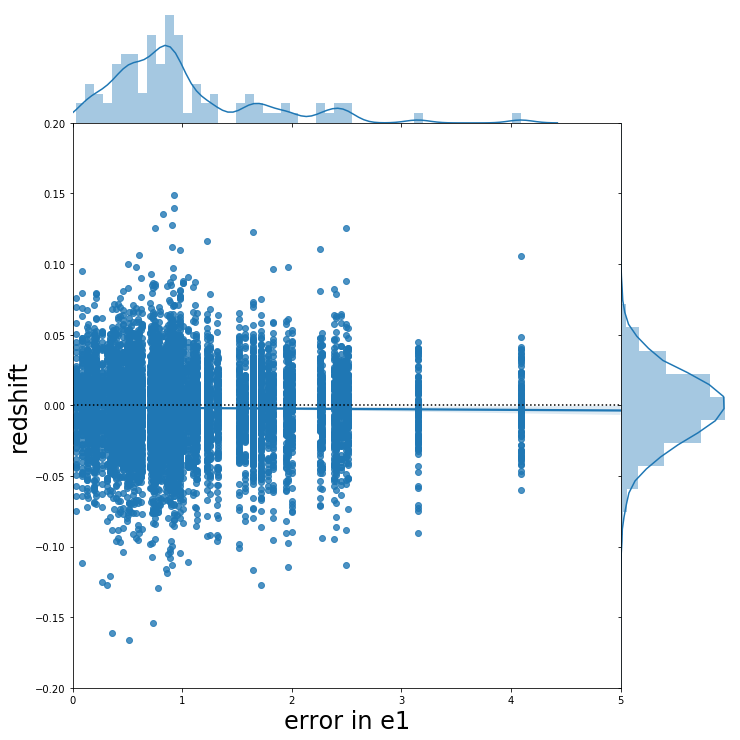

In [22]:
import seaborn as sns
g = sns.jointplot(redshift, error_R_e1, kind='reg',height =10
                  ,xlim =[0, 5], ylim=[-0.2, 0.2], space=0).set_axis_labels('error in e1', 'redshift', fontsize=24)
g.ax_joint.plot(np.linspace(0, 5),np.linspace(0,0), ':k')


In [23]:
import pandas as pd
df=pd.DataFrame()
df['redshift']=redshift
df['error on e1']=error_R_e1
df['error on e2']=error_R_e2
df['e1 input']= ellipticities_r_band[:,0,0]
df['e2 input']= ellipticities_r_band[:,0,1]

Text(0, 0.5, 'error on e2')

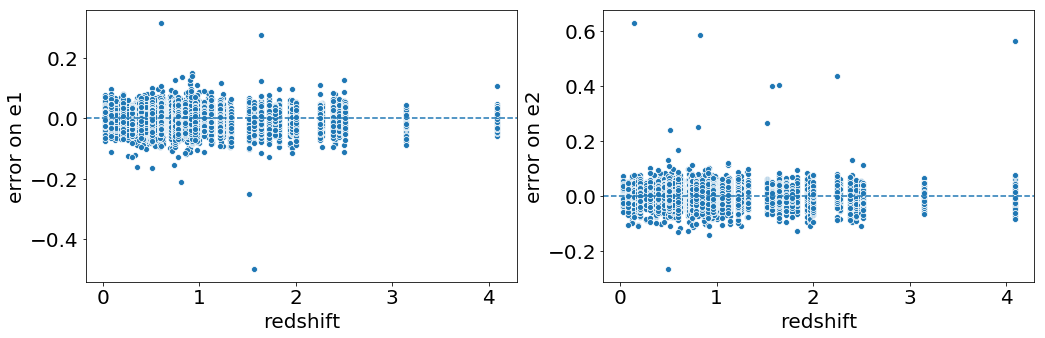

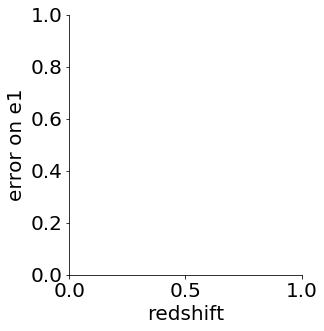

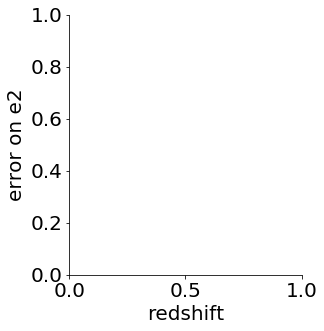

In [71]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,2, figsize=(17,5))
sns.relplot('redshift', 'error on e1', kind='scatter', data= df, ax = axes[0])
sns.relplot('redshift', 'error on e2', kind='scatter', data= df, ax = axes[1])
axes[0].axhline(y=0, ls='--')
axes[1].axhline(y=0, ls='--')
axes[0].set_xlabel('redshift')
axes[1].set_xlabel('redshift')
axes[0].set_ylabel('error on e1')
axes[1].set_ylabel('error on e2')

Text(0, 0.5, 'error on e2')

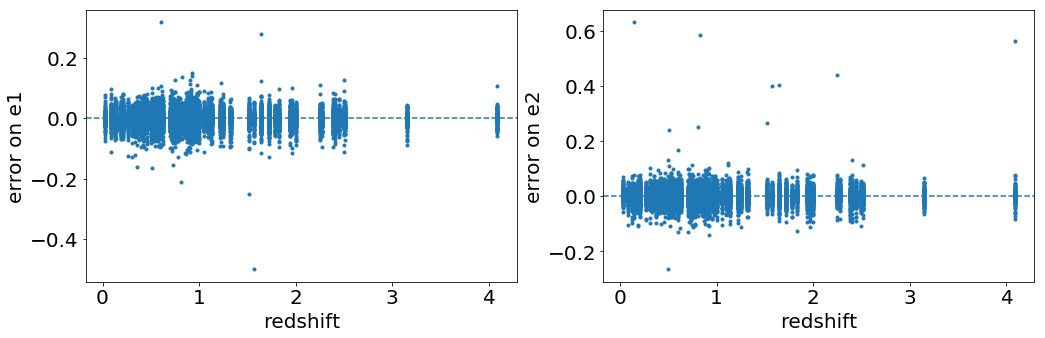

In [79]:
import matplotlib
ont = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,2, figsize=(17,5))
axes[0].plot(redshift, error_R_e1, '.')
axes[1].plot(redshift, error_R_e2, '.')
axes[0].axhline(y=0, ls='--')
axes[1].axhline(y=0, ls='--')
axes[0].set_xlabel('redshift')
axes[1].set_xlabel('redshift')
axes[0].set_ylabel('error on e1')
axes[1].set_ylabel('error on e2')

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


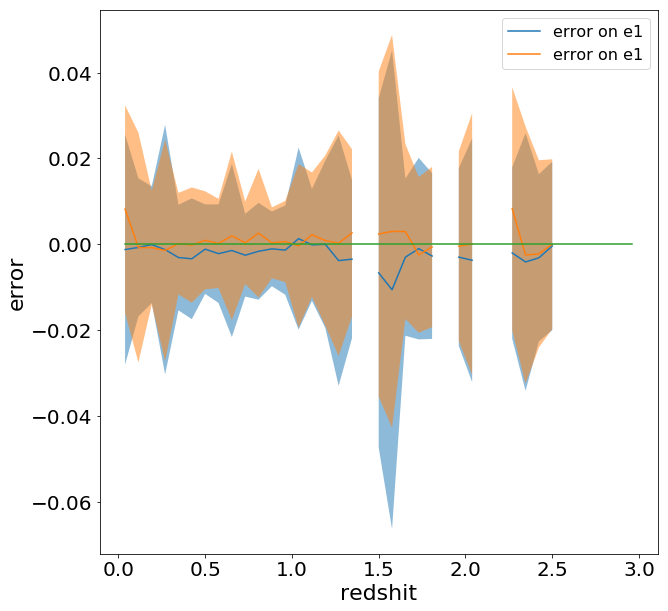

In [95]:
plt.figure(figsize=(10,10))

bins = np.linspace(0., 3,40)
mid = (bins[1:]+bins[:-1])*0.5
zeros = np.zeros((len(mid)))

mean_simple, var_simple = mean_var(redshift, error_R_e1,bins)

mean_e2, var_e2 = mean_var(redshift, error_R_e2,bins)

plt.plot(mid, mean_simple, label = 'error on e1')
plt.plot(mid, mean_e2, label = 'error on e1')
#plt.plot(mid, mean_multi)
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
plt.fill_between(mid, mean_e2 - 10*var_e2**0.5, mean_e2 + 10*var_e2**0.5, alpha=0.5)
plt.ylabel('error', fontsize = 22)
plt.xlabel('redshit', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid,zeros)

In [69]:
np.max(redshift)

4.088799953460693

In [98]:
a = np.where(redshift == np.max(redshift))

In [101]:
print(a)

(array([3089, 3090, 3091, 3092, 3093, 3094, 3095, 3096, 3097, 3098, 3099,
       3100, 3101, 3102, 3103, 3104, 3105, 3106, 3107, 3108, 3109, 3110,
       3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3119, 3120, 3121,
       3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132,
       3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143,
       3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154,
       3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165,
       3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176,
       3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187,
       3188]),)


In [100]:
for i in range (len(a)):
    print(ellipticities_r_band[a[i],0,0], ellipticities_r_band[a[i],0,1])

[-2.95834035e-01  4.34920341e-01 -3.68691117e-01  1.65666923e-01
 -6.29014820e-02  5.26172757e-01 -1.41940815e-02  3.03043872e-01
 -4.02613103e-01  1.82206891e-02  2.90642858e-01 -9.72395912e-02
 -2.67262459e-01  3.00506055e-01 -4.45315987e-02 -6.39075518e-01
  3.09919268e-01  2.78672646e-03 -2.48880252e-01  1.32119909e-01
  1.58277266e-02 -2.38273174e-01  1.74887225e-01  1.45872738e-02
  3.99578176e-02 -6.23571612e-02 -5.91793358e-02  2.27135941e-02
  1.30752817e-01 -1.34809494e-01  9.18733180e-02  3.08753014e-01
 -3.39855582e-01 -8.31378922e-02  1.14287846e-02 -9.13724229e-02
  9.96127948e-02 -5.67254201e-02  4.13757890e-01 -9.52357128e-02
  9.85273197e-02  7.09609166e-02 -6.26202822e-02 -7.57469013e-02
 -2.22299173e-02 -1.12956986e-01 -1.79457203e-01 -1.45263702e-01
  1.64010352e-03  1.14788368e-01  5.52806130e-04 -5.49454130e-02
  5.01551032e-02  1.19679645e-01 -3.05381771e-02  3.79837602e-02
 -1.35798231e-01 -2.95700222e-01  2.58635968e-01 -3.83561701e-01
  1.07906379e-01 -9.98138

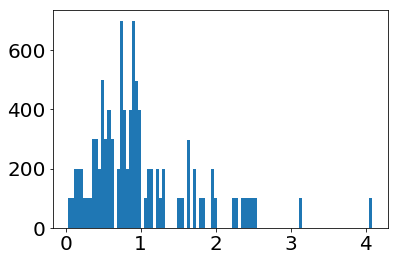

In [103]:
_ = plt.hist(redshift, bins = 100)

Text(0, 0.5, 'error on e2')

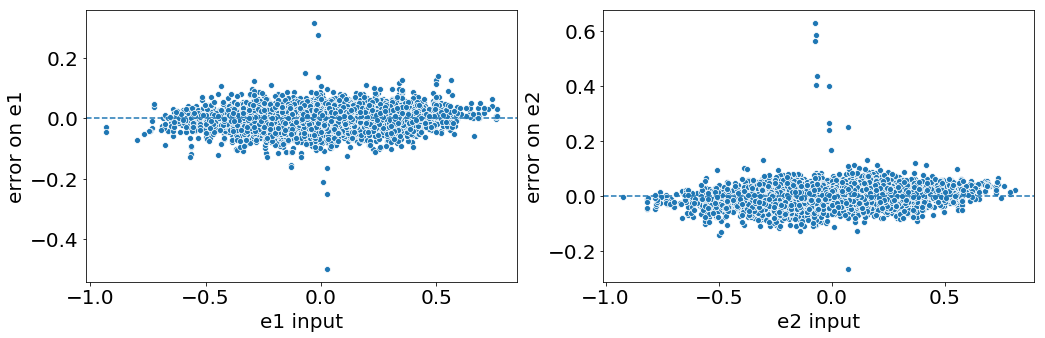

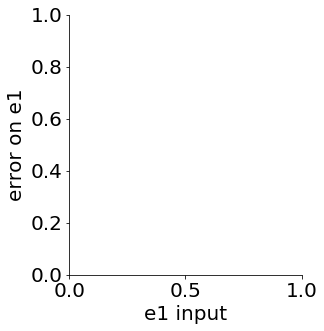

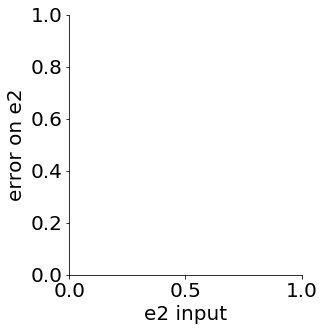

In [68]:
import matplotlib
ont = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

fig, axes = plt.subplots(1,2, figsize=(17,5))
sns.relplot('e1 input', 'error on e1', kind='scatter', data= df, ax = axes[0])
sns.relplot('e2 input', 'error on e2', kind='scatter', data= df, ax = axes[1])
axes[0].axhline(y=0, ls='--')
axes[1].axhline(y=0, ls='--')
axes[0].set_xlabel('e1 input')
axes[1].set_xlabel('e2 input')
axes[0].set_ylabel('error on e1')
axes[1].set_ylabel('error on e2')

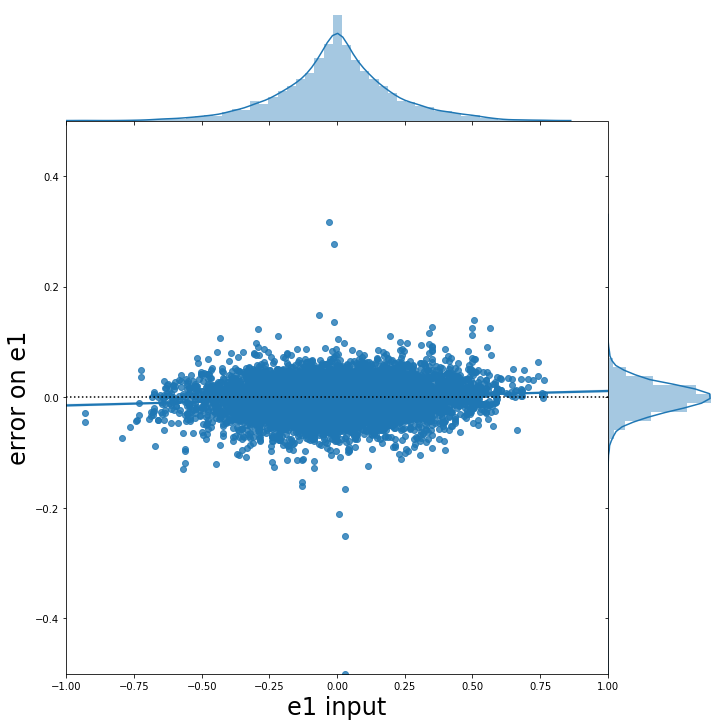

In [35]:
g = sns.jointplot('e1 input', 'error on e1', kind='reg',data = df,height =10
                  ,xlim =[-1, 1], ylim=[-0.5, 0.5], space=0).set_axis_labels('e1 input', 'error on e1', fontsize=24)
g.ax_joint.plot(np.linspace(-1, 5),np.linspace(0,0), ':k')


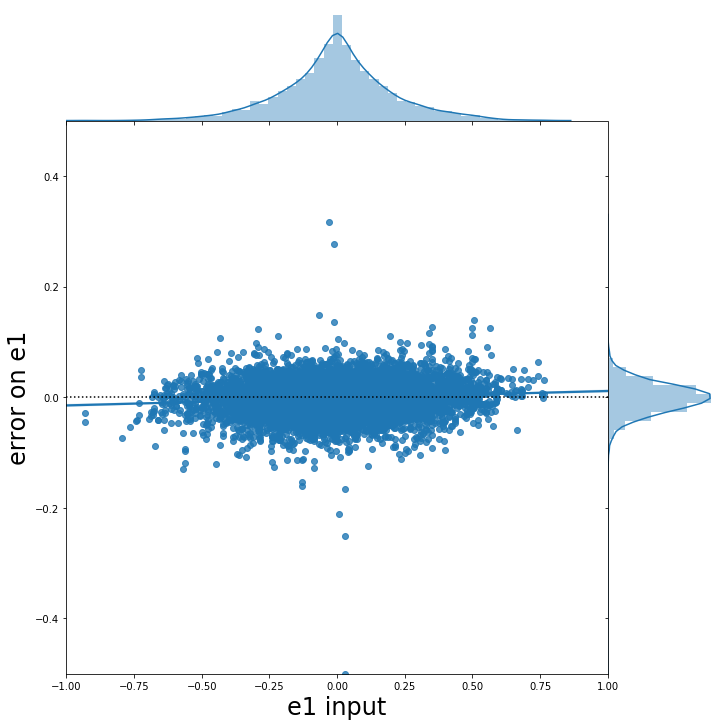

In [36]:
g = sns.jointplot('e1 input', 'error on e1', kind='reg',data = df,height =10
                  ,xlim =[-1, 1], ylim=[-0.5, 0.5], space=0).set_axis_labels('e1 input', 'error on e1', fontsize=24)
g.ax_joint.plot(np.linspace(-1, 5),np.linspace(0,0), ':k')


In [ ]:
sns.catplot(x="redshift", y="error on e1", hue="error on e2",
            kind="violin", bw=.15, cut=0,
            data=df);

KeyboardInterrupt: 

(0, 3)

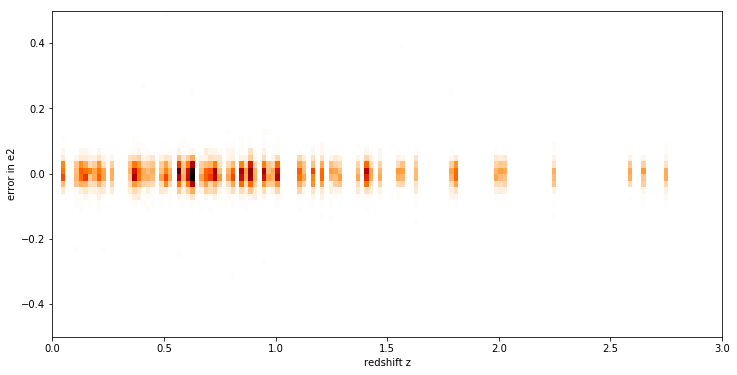

In [21]:
# Redshift
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.hist2d(redshift, error_R_e2, bins=np.linspace(-5,5,501), cmap=mpl.cm.gist_heat_r)
plt.xlabel('redshift z')
plt.ylabel('error in e2')
plt.ylim(-0.5,0.5)
plt.xlim(0,3)

#### LSST

In [18]:
# LSST
error_LSST_e1 = ellipticities[:,0,0] - ellipticities[:,1,0]
error_LSST_e2 = ellipticities[:,0,1] - ellipticities[:,1,1]

redshift = np.zeros((len(redshift_LSST)))
for i in range (len(redshift_LSST)):
    redshift[i] = redshift_LSST[i][0]

(0, 3)

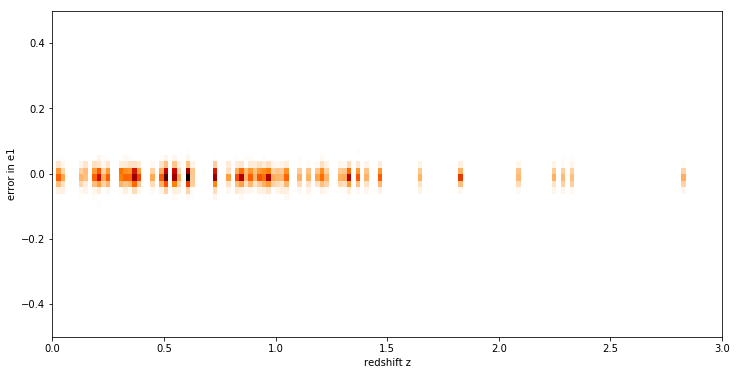

In [19]:
# Redshift
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.hist2d(redshift, error_LSST_e1, bins=np.linspace(-5,5,501), cmap=mpl.cm.gist_heat_r)
plt.xlabel('redshift z')
plt.ylabel('error in e1')
plt.ylim(-0.5,0.5)
plt.xlim(0,3)

(0, 3)

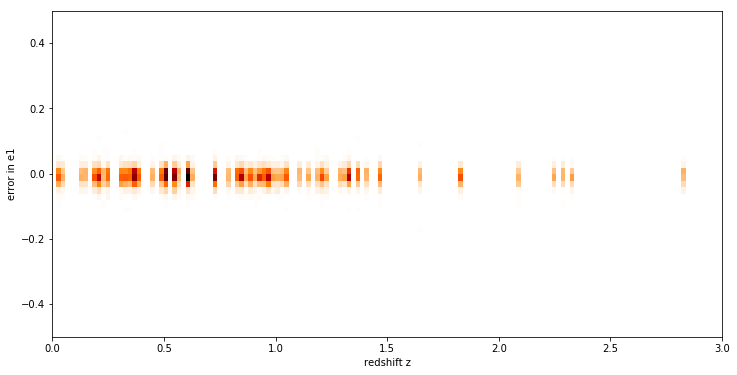

In [20]:
# Redshift
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.hist2d(redshift, error_LSST_e2, bins=np.linspace(-5,5,501), cmap=mpl.cm.gist_heat_r)
plt.xlabel('redshift z')
plt.ylabel('error in e1')
plt.ylim(-0.5,0.5)
plt.xlim(0,3)

#### LSST + Euclid

In [ ]:
# LSST + Euclid
error_LSST_Eucid_e1 = ellipticities_LSST_euclid[:,0,0] - ellipticities_LSST_euclid[:,1,0]
error_LSST_Eucid_e2 = ellipticities_LSST_euclid[:,0,1] - ellipticities_LSST_euclid[:,1,1]

redshift = np.zeros((len(redshift_LSST_euclid)))
for i in range (len(redshift_LSST_euclid)):
    redshift[i] = redshift_LSST_euclid[i][0]

In [ ]:
# Redshift
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.hist2d(redshift, error_LSST_Euclid_e1, bins=np.linspace(-5,5,501), cmap=mpl.cm.gist_heat_r)
plt.xlabel('redshift z')
plt.ylabel('error in e1')
plt.ylim(-0.5,0.5)
plt.xlim(0,3)

In [ ]:
# Redshift
fig, axes = plt.subplots(1,1, figsize=(12,6))

axes.hist2d(redshift, error_LSST_Euclid_e2, bins=np.linspace(-5,5,501), cmap=mpl.cm.gist_heat_r)
plt.xlabel('redshift z')
plt.ylabel('error in e1')
plt.ylim(-0.5,0.5)
plt.xlim(0,3)

## luminosity comparison

In [19]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [20]:
N = 100

In [20]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')

delta_lum_simple= np.empty([N,], dtype='float32')

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    list_galsim_simple = batch_gen.__getitem__(2)
    list_gal_out_simple = vae_lsst_r_band_conv.predict(list_galsim_simple[0], batch_size= 100)
    for j in range (len(list_galsim_simple[0])):
        mask = createCircularMask(64,64,None,5)
        masked_img_in_simple = list_galsim_simple[1][j].copy()
        masked_img_in_simple[~mask] = 0  

        masked_img_out_simple = list_gal_out_simple[j].copy()
        masked_img_out_simple[~mask] = 0

        # Calculate the luminosity by substracting the noise
        lum_in_simple[i,j] = np.sum(masked_img_in_simple)
        #print(lum_in_simple[i,j])
        lum_out_simple[i,j] = np.sum(masked_img_out_simple)
        #print(lum_out_simple[i,j])

In [43]:
lum_in_simple.shape

(100, 100)

In [21]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

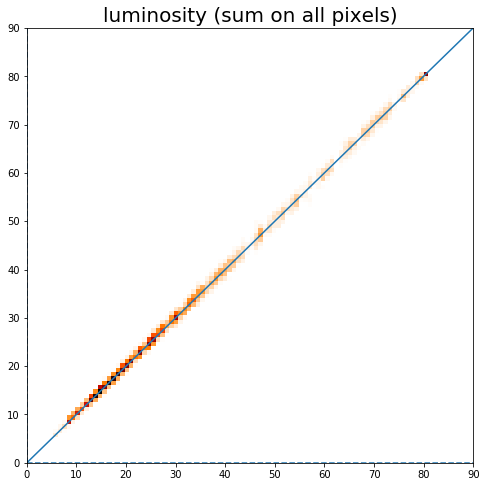

In [24]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 90
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

## LSST

In [53]:
N=5

In [57]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,100,],dtype='float32')
lum_out_simple= np.empty([N,100,], dtype='float32')

delta_lum_simple= np.empty([N,], dtype='float32')

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    list_galsim_simple = batch_gen_lsst.__getitem__(2)
    list_gal_out_simple = vae_lsst_conv.predict(list_galsim_simple[0], batch_size= 100).reshape(100,6,64,64)
    for j in range (len(list_galsim_simple[0])):
        mask = createCircularMask(64,64,None,5)
        masked_img_in_simple = list_galsim_simple[1].reshape(100,6,64,64)[j,2].copy()
        masked_img_in_simple[~mask] = 0  

        masked_img_out_simple = list_gal_out_simple[j,2].copy()
        masked_img_out_simple[~mask] = 0

        # Calculate the luminosity by substracting the noise
        print("Dans le batch, numéro : "+str(j))
        lum_in_simple[i,j] = np.sum(masked_img_in_simple)
        print(lum_in_simple[i,j])
        lum_out_simple[i,j] = np.sum(masked_img_out_simple)
        print(lum_out_simple[i,j])
        

Dans le batch, numéro : 0
10.091092
9.937936
Dans le batch, numéro : 1
2.1821136
2.1842225
Dans le batch, numéro : 2
37.513683
35.237503
Dans le batch, numéro : 3
50.85068
48.67398
Dans le batch, numéro : 4
5.6957154
5.788907
Dans le batch, numéro : 5
10.540577
9.119222
Dans le batch, numéro : 6
3.7784603
3.9764981
Dans le batch, numéro : 7
5.2676396
5.219083
Dans le batch, numéro : 8
7.460955
7.520817
Dans le batch, numéro : 9
20.869904
20.500053
Dans le batch, numéro : 10
20.00919
18.503004
Dans le batch, numéro : 11
8.964011
9.280821
Dans le batch, numéro : 12
2.8883781
2.5984497
Dans le batch, numéro : 13
6.1947694
6.4829187
Dans le batch, numéro : 14
40.039154
39.874832
Dans le batch, numéro : 15
11.370293
10.904741
Dans le batch, numéro : 16
3.8243577
4.232381
Dans le batch, numéro : 17
14.645642
15.229193
Dans le batch, numéro : 18
3.03308
2.8711967
Dans le batch, numéro : 19
8.667035
10.043197
Dans le batch, numéro : 20
30.007538
29.596931
Dans le batch, numéro : 21
5.76736
5.4

Dans le batch, numéro : 0
19.649853
20.055767
Dans le batch, numéro : 1
6.29525
5.4833145
Dans le batch, numéro : 2
6.798847
7.730811
Dans le batch, numéro : 3
2.8613188
2.6137803
Dans le batch, numéro : 4
6.384707
6.566553
Dans le batch, numéro : 5
8.573963
8.070901
Dans le batch, numéro : 6
2.4171722
2.522388
Dans le batch, numéro : 7
3.4857543
3.5839863
Dans le batch, numéro : 8
2.980196
2.6548738
Dans le batch, numéro : 9
3.4492464
3.827342
Dans le batch, numéro : 10
4.4775176
5.575328
Dans le batch, numéro : 11
12.037053
12.602222
Dans le batch, numéro : 12
3.0254624
3.279756
Dans le batch, numéro : 13
63.511566
68.90989
Dans le batch, numéro : 14
25.141373
22.79561
Dans le batch, numéro : 15
5.982938
6.072486
Dans le batch, numéro : 16
2.6867197
2.7536378
Dans le batch, numéro : 17
2.2727616
1.9850717
Dans le batch, numéro : 18
4.168472
4.681512
Dans le batch, numéro : 19
4.050687
3.824301
Dans le batch, numéro : 20
2.7974005
2.5796
Dans le batch, numéro : 21
4.5017447
5.127453
D

Dans le batch, numéro : 0
43.45232
43.670853
Dans le batch, numéro : 1
4.3443284
3.8825312
Dans le batch, numéro : 2
21.37157
19.470678
Dans le batch, numéro : 3
6.615872
7.1958466
Dans le batch, numéro : 4
6.593129
6.5207634
Dans le batch, numéro : 5
7.9106693
9.471848
Dans le batch, numéro : 6
3.310524
3.0829022
Dans le batch, numéro : 7
4.872607
4.816928
Dans le batch, numéro : 8
20.210981
23.160336
Dans le batch, numéro : 9
12.833779
15.642637
Dans le batch, numéro : 10
3.0298734
3.4718468
Dans le batch, numéro : 11
31.253824
26.62211
Dans le batch, numéro : 12
69.99792
73.364975
Dans le batch, numéro : 13
5.860531
5.923561
Dans le batch, numéro : 14
14.259986
15.084028
Dans le batch, numéro : 15
3.5827787
3.3875246
Dans le batch, numéro : 16
20.670456
21.860455
Dans le batch, numéro : 17
1.883604
1.9031825
Dans le batch, numéro : 18
7.4067583
6.9980116
Dans le batch, numéro : 19
8.187228
7.805497
Dans le batch, numéro : 20
3.3586652
3.390246
Dans le batch, numéro : 21
3.417468
3.2

In [58]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

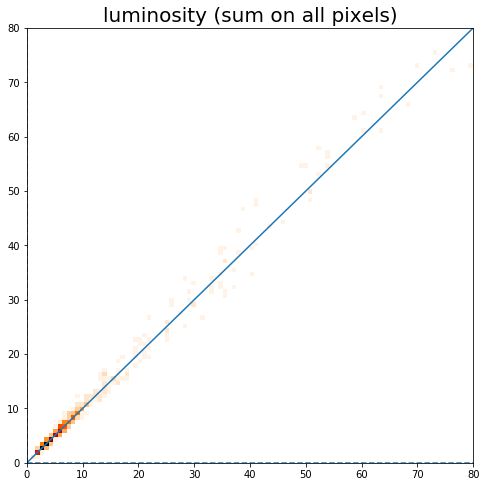

In [59]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 80
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

## LSST + Euclid

In [ ]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')

delta_lum_simple= np.empty([N,], dtype='float32')

fig=plt.figure(figsize=(6*3,30*3))
columns = 4
rows =10
cont = 0

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    list_galsim_simple = batch_gen_lsst_euclid.__getitem__(2)[0]
    list_gal_out_simple = vae_lsst_euclid_conv.predict(list_galsim_simple, batch_size= 100).reshape((100,10,64,64))
    for j in range (len(list_galsim_simple)):
        mask = createCircularMask(64,64,None,5)
        masked_img_in_simple = list_galsim_simple.reshape((100,10,64,64))[j,6].copy()
        masked_img_in_simple[~mask] = 0  

        masked_img_out_simple = list_gal_out_simple[j,6].copy()
        masked_img_out_simple[~mask] = 0

        # Calculate the luminosity by substracting the noise
        lum_in_simple[i,j] = np.sum(masked_img_in_simple)
        lum_out_simple[i,j] = np.sum(masked_img_out_simple)

In [ ]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

In [ ]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(6,6))
emax = 80
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,101), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', color="w", fontsize=20)
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

In [40]:
def mean_var(x,y,bins):

    n,_ = np.histogram(x,bins=bins, weights=None)
    ny,_ = np.histogram(x,bins=bins, weights=y)
    mean_y = ny/n
    ny2,_ = np.histogram(x,bins=bins, weights=y**2)
    var_y = (ny2/n - mean_y**2)/n
    
    return (mean_y, var_y)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


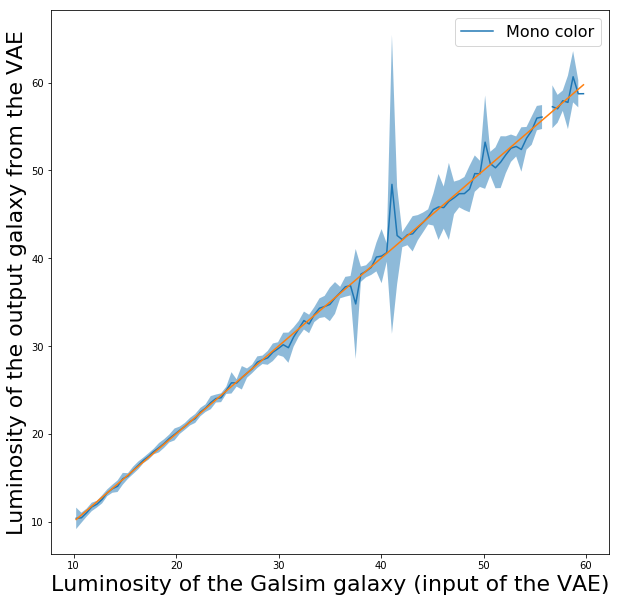

In [46]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 60, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple,lum_out_simple,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

## Comparison with VAE R filter only

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


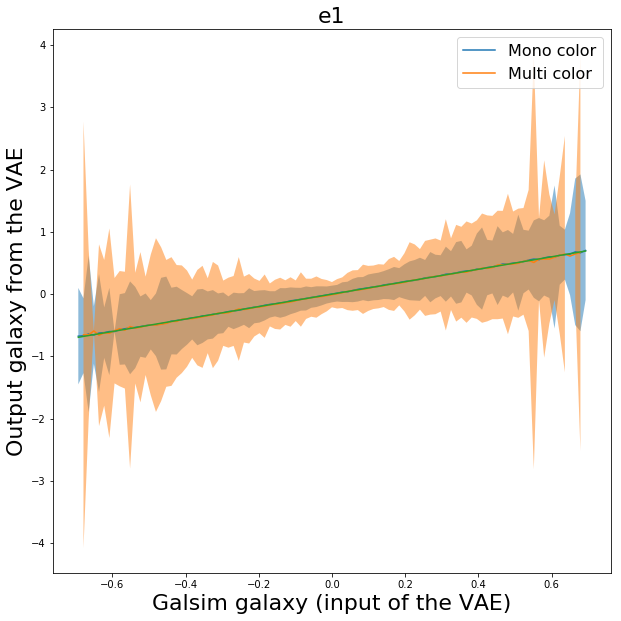

In [41]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,0],ellipticities_r_band[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities[:,0,0],ellipticities[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

#plt.spines['bottom'].set_color('w')
#plt.spines['right'].set_color('w')
#plt.spines['left'].set_color('w')
#plt.spines['top'].set_color('w')
#plt.xaxis.label.set_color('w')
#plt.tick_params(axis='x', colors='w')
#plt.tick_params(axis='y', colors='w')

plt.plot(mid, mid)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


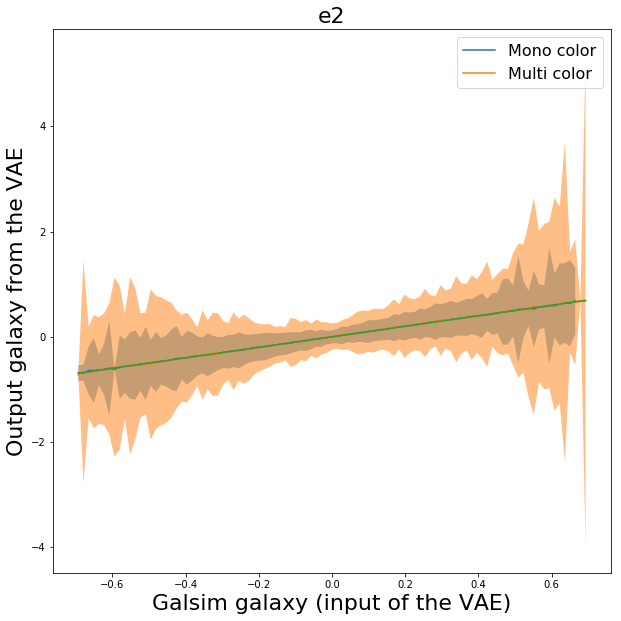

In [42]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities_r_band[:,0,1],ellipticities_r_band[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities[:,0,1],ellipticities[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

#### LSST compared to LSST+EUCLID

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


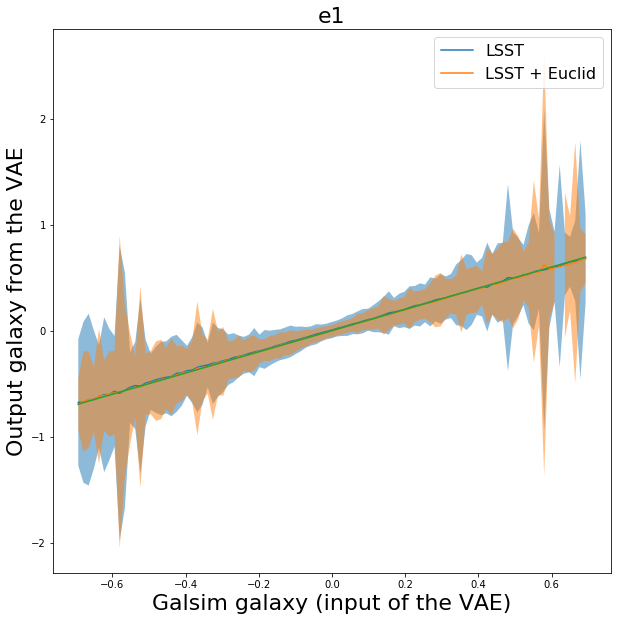

In [68]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities[:,0,0],ellipticities[:,1,0],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,0],ellipticities_LSST_euclid[:,1,0],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e1', fontsize = 22)
plt.legend(fontsize = 16)

#plt.spines['bottom'].set_color('w')
#plt.spines['right'].set_color('w')
#plt.spines['left'].set_color('w')
#plt.spines['top'].set_color('w')
#plt.xaxis.label.set_color('w')
#plt.tick_params(axis='x', colors='w')
#plt.tick_params(axis='y', colors='w')

plt.plot(mid, mid)

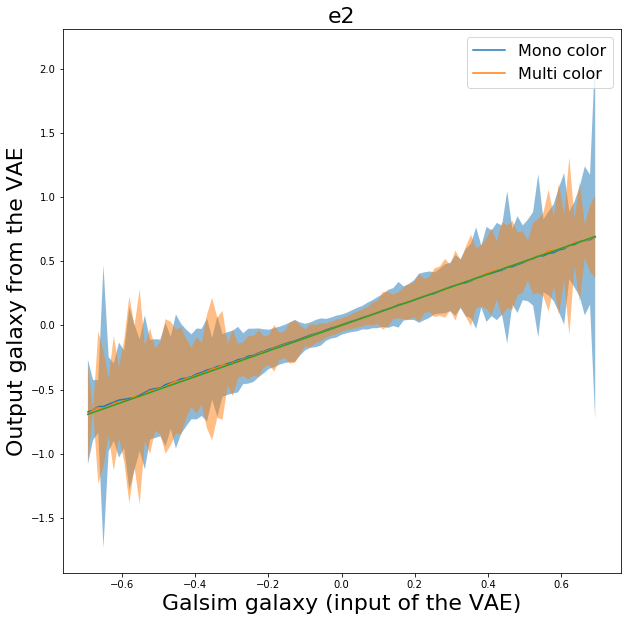

In [69]:
plt.figure(figsize=(10,10))

bins = np.linspace(-0.7, 0.7, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(ellipticities[:,0,1],ellipticities[:,1,1],bins)
mean_multi, var_multi = mean_var(ellipticities_LSST_euclid[:,0,1],ellipticities_LSST_euclid[:,1,1],bins)

plt.plot(mid, mean_simple, label = 'LSST')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'LSST + Euclid')
plt.fill_between(mid, mean_simple - 100*var_simple**0.5, mean_simple + 100*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 100*var_multi**0.5, mean_multi + 100*var_multi**0.5, alpha=0.5)
plt.ylabel('Output galaxy from the VAE', fontsize = 22)
plt.xlabel('Galsim galaxy (input of the VAE)', fontsize = 22)
plt.title('e2', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

In [ ]:
input_vae_lsst, input_vae_no_noise_lsst = load_test_data('/sps/lsst/users/barcelin/data/galaxies_COSMOS_test_v4.npy','LSST')
input_vae_lsst_r_band, input_vae_no_noise_lsst_r_band = load_test_data('/sps/lsst/users/barcelin/data/galaxies_COSMOS_test_v4.npy','LSST_R_BAND')

In [18]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,],dtype='float32')
lum_in_multi= np.empty([N,], dtype='float32')
lum_out_simple= np.empty([N,], dtype='float32')
lum_out_multi= np.empty([N,], dtype='float32')


delta_lum_simple= np.empty([N,], dtype='float32')
delta_lum_multi= np.empty([N,], dtype='float32')

fig=plt.figure(figsize=(6*3,30*3))
columns = 4
rows =10
cont = 0

list_galsim_simple = input_vae_no_noise_lsst_r_band
list_galsim_multi = input_vae_no_noise_lsst

list_gal_out_simple = vae_lsst_r_band.predict(input_vae_lsst_r_band, batch_size= 100)
list_gal_out_multi = vae_lsst_2000.predict(input_vae_lsst, batch_size= 100)

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    mask = createCircularMask(64,64,None,5)
    masked_img_in_simple = list_galsim_simple[i].copy()
    masked_img_in_simple[~mask] = 0  
    
    masked_img_in_multi = list_galsim_multi[i].reshape(6,64,64)[3].copy()
    masked_img_in_multi[~mask] = 0

    masked_img_out_simple = list_gal_out_simple[i].copy()
    masked_img_out_simple[~mask] = 0

    masked_img_out_multi = list_gal_out_multi[i].reshape(6,64,64)[3].copy()
    masked_img_out_multi[~mask] = 0

    # Calculate the luminosity by substracting the noise
    lum_in_simple[i] = np.sum(masked_img_in_simple)
    lum_out_simple[i] = np.sum(masked_img_out_simple)
    lum_in_multi[i] = np.sum(masked_img_in_multi)
    lum_out_multi[i] = np.sum(masked_img_out_multi)


    # Calculate the differences between input and output of deblender
    delta_lum_simple[i] = (lum_in_simple[i] - lum_out_simple[i])#/lum_in_1[i]
    delta_lum_multi[i] = (lum_in_multi[i] - lum_out_multi[i])#/lum_in_2[i]

<Figure size 1296x6480 with 0 Axes>

In [19]:
print(lum_in_simple, lum_out_simple)

[31.714296  12.519497  25.535929  ...  6.3283587 18.49002   28.707935 ] [42.99124  31.833992 23.249805 ... 14.619323 20.268929 43.34626 ]


/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


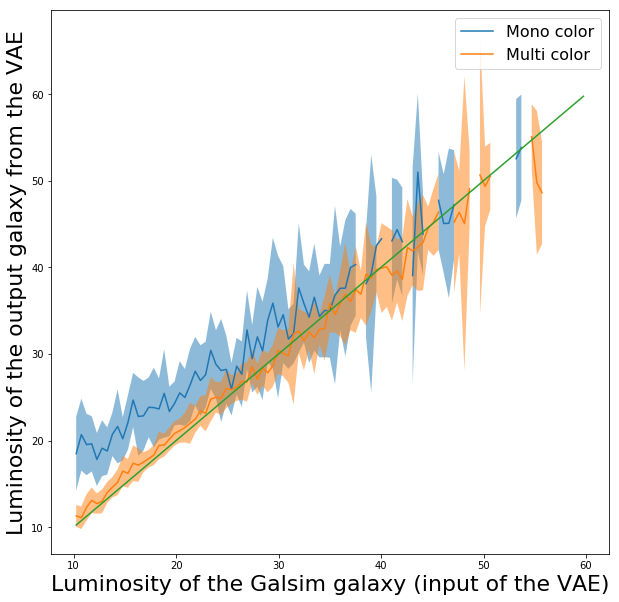

In [31]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 60, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple,lum_out_simple,bins)
mean_multi, var_multi = mean_var(lum_in_multi,lum_out_multi,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

In [32]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,],dtype='float32')
lum_in_multi= np.empty([N,], dtype='float32')
lum_out_simple= np.empty([N,], dtype='float32')
lum_out_multi= np.empty([N,], dtype='float32')


delta_lum_simple= np.empty([N,], dtype='float32')
delta_lum_multi= np.empty([N,], dtype='float32')

fig=plt.figure(figsize=(6*3,30*3))
columns = 4
rows =10
cont = 0

list_galsim_simple = input_vae_no_noise_lsst_r_band
list_galsim_multi = input_vae_no_noise_lsst

list_gal_out_simple = vae_lsst_r_band.predict(input_vae_lsst_r_band, batch_size= 100)
list_gal_out_multi = vae_lsst_2000.predict(input_vae_lsst, batch_size= 100)

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    mask = createCircularMask(64,64,None,10)
    masked_img_in_simple = list_galsim_simple[i].copy()
    masked_img_in_simple[~mask] = 0  
    
    masked_img_in_multi = list_galsim_multi[i].reshape(6,64,64)[3].copy()
    masked_img_in_multi[~mask] = 0

    masked_img_out_simple = list_gal_out_simple[i].copy()
    masked_img_out_simple[~mask] = 0

    masked_img_out_multi = list_gal_out_multi[i].reshape(6,64,64)[3].copy()
    masked_img_out_multi[~mask] = 0

    # Calculate the luminosity by substracting the noise
    lum_in_simple[i] = np.sum(masked_img_in_simple)
    lum_out_simple[i] = np.sum(masked_img_out_simple)
    lum_in_multi[i] = np.sum(masked_img_in_multi)
    lum_out_multi[i] = np.sum(masked_img_out_multi)


    # Calculate the differences between input and output of deblender
    delta_lum_simple[i] = (lum_in_simple[i] - lum_out_simple[i])#/lum_in_1[i]
    delta_lum_multi[i] = (lum_in_multi[i] - lum_out_multi[i])#/lum_in_2[i]

<Figure size 1296x6480 with 0 Axes>

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


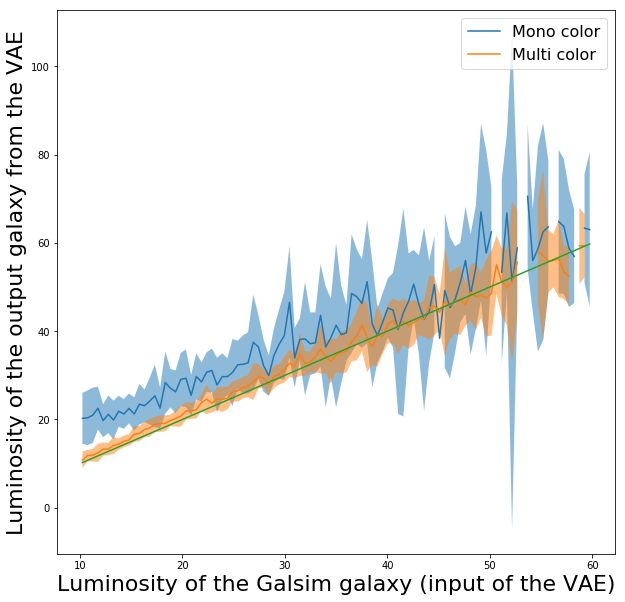

In [33]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 60, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple,lum_out_simple,bins)
mean_multi, var_multi = mean_var(lum_in_multi,lum_out_multi,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

In [36]:
# initialize some arrays to zero
lum_in_simple = np.empty([N,],dtype='float32')
lum_in_multi= np.empty([N,], dtype='float32')
lum_out_simple= np.empty([N,], dtype='float32')
lum_out_multi= np.empty([N,], dtype='float32')


delta_lum_simple= np.empty([N,], dtype='float32')
delta_lum_multi= np.empty([N,], dtype='float32')

fig=plt.figure(figsize=(6*3,30*3))
columns = 4
rows =10
cont = 0

list_galsim_simple = input_vae_no_noise_lsst_r_band
list_galsim_multi = input_vae_no_noise_lsst

list_gal_out_simple = vae_lsst_r_band.predict(input_vae_lsst_r_band, batch_size= 100)
list_gal_out_multi = vae_lsst_2000.predict(input_vae_lsst, batch_size= 100)

# Calculate the luminosity as the total luminosity of the image: sum over all the pixels
for i in range (N):
    # Circular mask to evaluate the luminosity in that circle
    mask = createCircularMask(64,64,None,32)
    masked_img_in_simple = list_galsim_simple[i].copy()
    masked_img_in_simple[~mask] = 0  
    
    masked_img_in_multi = list_galsim_multi[i].reshape(6,64,64)[3].copy()
    masked_img_in_multi[~mask] = 0

    masked_img_out_simple = list_gal_out_simple[i].copy()
    masked_img_out_simple[~mask] = 0

    masked_img_out_multi = list_gal_out_multi[i].reshape(6,64,64)[3].copy()
    masked_img_out_multi[~mask] = 0

    # Calculate the luminosity by substracting the noise
    lum_in_simple[i] = np.sum(masked_img_in_simple)
    lum_out_simple[i] = np.sum(masked_img_out_simple)
    lum_in_multi[i] = np.sum(masked_img_in_multi)
    lum_out_multi[i] = np.sum(masked_img_out_multi)


    # Calculate the differences between input and output of deblender
    delta_lum_simple[i] = (lum_in_simple[i] - lum_out_simple[i])#/lum_in_1[i]
    delta_lum_multi[i] = (lum_in_multi[i] - lum_out_multi[i])#/lum_in_2[i]

<Figure size 1296x6480 with 0 Axes>

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


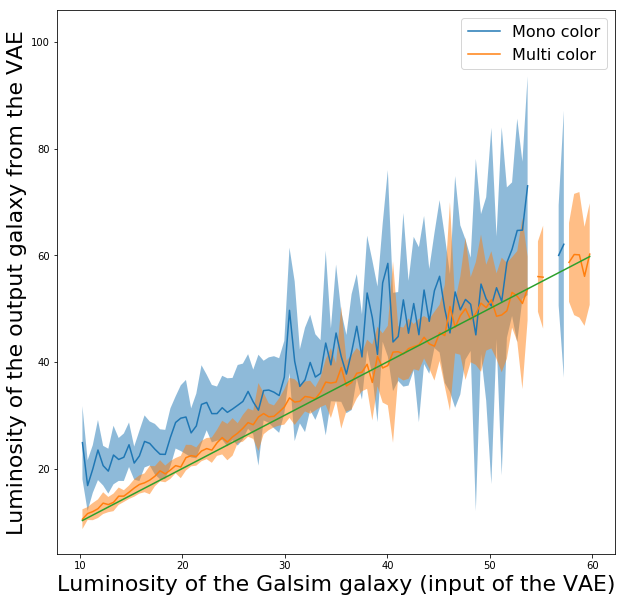

In [37]:
plt.figure(figsize=(10,10))

bins = np.linspace(10., 60, 100)
mid = (bins[1:]+bins[:-1])*0.5

mean_simple, var_simple = mean_var(lum_in_simple,lum_out_simple,bins)
mean_multi, var_multi = mean_var(lum_in_multi,lum_out_multi,bins)

plt.plot(mid, mean_simple, label = 'Mono color')
#plt.plot(mid, mean_multi)
plt.plot(mid, mean_multi, label = 'Multi color')
plt.fill_between(mid, mean_simple - 10*var_simple**0.5, mean_simple + 10*var_simple**0.5, alpha=0.5)
#plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.fill_between(mid, mean_multi - 10*var_multi**0.5, mean_multi + 10*var_multi**0.5, alpha=0.5)
plt.ylabel('Luminosity of the output galaxy from the VAE', fontsize = 22)
plt.xlabel('Luminosity of the Galsim galaxy (input of the VAE)', fontsize = 22)
plt.legend(fontsize = 16)
plt.plot(mid, mid)

# Test N iterations of the same galaxy

In [13]:
input_R = batch_gen.__getitem__(56)

In [15]:
input_R[0].shape

(100, 64, 64)

In [19]:
input_lsst = batch_gen_lsst.__getitem__(56)

In [24]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

measures=[]
e_mes=[]
for i in range (1000):
    output_vae = vae_lsst_conv.predict(input_lsst[0], batch_size = batch_size)
    gal_image = galsim.Image(output_vae[0].reshape((6,64,64))[2])
    gal_image.scale = pix_scale
    measures= galsim.hsm.EstimateShear(gal_image, psf_image)
    e_mes.append([measures.corrected_e1, measures.corrected_e2])

In [ ]:
e1 = np.concatenate(e_mes, axis = 0)
e2 = np.concatenate(e_mes, axis = 1)

In [ ]:
e1.shape, e2.shape

In [ ]:
_ = plt.hist(e_mes)